### Setup

In [4]:
# External libraries used for various tasks in later parts of the code
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from imutils import paths
import torch
import torch.nn as nn
import time
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm
import os

# Check if running on Google Colab and set the data paths accordingly
is_running_on_colab = 'COLAB_GPU' in os.environ
if is_running_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    train_path = '/content/gdrive/MyDrive/license_plate/train/'
    val_path = '/content/gdrive/MyDrive/license_plate/val/'
    test_path = '/content/gdrive/MyDrive/license_plate/test/'
else:
    current_dir = os.getcwd()
    train_path = os.path.join(current_dir, 'dataset', 'license_plate', 'train')
    val_path = os.path.join(current_dir, 'dataset', 'license_plate', 'val')
    test_path = os.path.join(current_dir, 'dataset', 'license_plate', 'test')

# Function to check if directories exist
def check_directories_exist(*paths):
    for path in paths:
        assert os.path.isdir(path), f"The directory {path} does not exist."

# Check the directories
check_directories_exist(train_path, val_path, test_path)

# Sets device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_PATH = [train_path]
VAL_PATH = [val_path]
TEST_PATH = [test_path]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Check how many images in data-split**

In [5]:
# Function to count files in a directory
def count_files_in_directory(directory):
    return len(os.listdir(directory))

# Check the number of files in each path
train_files = count_files_in_directory(train_path)
val_files = count_files_in_directory(val_path)
test_files = count_files_in_directory(test_path)

# Print the results
print(f"Number of files in train path: {train_files}")
print(f"Number of files in val path: {val_files}")
print(f"Number of files in test path: {test_files}")



Number of files in train path: 5769
Number of files in val path: 1001
Number of files in test path: 5007


### DataLoader


In [6]:
from torch.utils.data import Dataset
import cv2
from imutils import paths
import os
import torch

class LabelFpsDataLoader(Dataset):
    def __init__(self, img_dirs, img_size, is_transform=None, normalize_labels=False):
        self.img_paths = [p for img_dir in img_dirs for p in paths.list_images(img_dir)]
        self.img_size = img_size
        self.is_transform = is_transform
        self.normalize_labels = normalize_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_name = self.img_paths[index]
        img = cv2.imread(img_name)
        resized_image = self.transform_image(img)

        file_name = os.path.splitext(os.path.basename(img_name))[0]
        labels = self.extract_labels(file_name, img.shape)

        return resized_image, labels, img_name

    def transform_image(self, img):
        resized_image = cv2.resize(img, self.img_size).astype('float32') / 255.0
        # Normalization - Adjust mean and std if necessary
        mean = np.array([0.485, 0.456, 0.406], dtype=resized_image.dtype)
        std = np.array([0.229, 0.224, 0.225],dtype=resized_image.dtype)

        resized_image = (resized_image - mean) / std  # Normalize
        return resized_image

    def extract_labels(self, file_name, img_shape):
        parts = file_name.split('-')
        points = [self.parse_point(part) for part in parts[2].split('_')]
        ori_w, ori_h = img_shape[1], img_shape[0]
        scale_w, scale_h = self.img_size[0] / ori_w, self.img_size[1] / ori_h
        scaled_points = [(int(x * scale_w), int(y * scale_h)) for x, y in points]
        if self.normalize_labels:
          scaled_points = [(x / self.img_size[0], y / self.img_size[1]) for x, y in scaled_points]
        flattened_labels = [coord for point in scaled_points for coord in point]
        return torch.tensor(flattened_labels, dtype=torch.float32)

    @staticmethod
    def parse_point(point_str):
        return tuple(int(coord) for coord in point_str.split('&'))


### Helper methods

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def plot_img_and_boundingbox(image, labels):
    # Assuming image is a PyTorch tensor, we need to first move it to CPU if it's on GPU,
    # then detach it from the current graph, convert to numpy, and finally transpose it
    # from (channels, height, width) to (height, width, channels)
    numpy_array = image.cpu().detach().numpy()

    # Convert from BGR to RGB format if the image was read by OpenCV
    rgb_image = cv2.cvtColor(numpy_array, cv2.COLOR_BGR2RGB)

    # Extract numerical values from tensors and convert to integers
    left_up = (int(labels[0]), int(labels[1]))
    right_down = (int(labels[2]), int(labels[3]))

    # Draw rectangle on the image
    new_image = cv2.rectangle(rgb_image, left_up, right_down, (255, 0, 0), 2)

    # Display the image
    plt.imshow(new_image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage:
# img, labels, _ = dataset[0]  # Assuming this is how you get an image and labels from your dataset
# plot_img_and_boundingbox(img, labels)


In [8]:
def save_model(model):
  # Get the current time
  current_time = datetime.now()

  # Format the time in a 'YearMonthDay_HourMinuteSecond' format for the filename
  timestamp = current_time.strftime('%Y%m%d_%H%M')
  model_path = f'/content/gdrive/MyDrive/license_plate/models/model_weights_{timestamp}.pth'
  torch.save(model.state_dict(), model_path)

def load_model(path):
  model.load_state_dict(torch.load(path))

In [9]:
def bb_intersection_over_union(boxA, boxB):
    # Compute the intersection over union on GPU
    # Assumes boxA and boxB are tensors
    xA = torch.max(boxA[..., 0], boxB[..., 0])
    yA = torch.max(boxA[..., 1], boxB[..., 1])
    xB = torch.min(boxA[..., 2], boxB[..., 2])
    yB = torch.min(boxA[..., 3], boxB[..., 3])

    interArea = torch.clamp(xB - xA, min=0) * torch.clamp(yB - yA, min=0)

    boxAArea = (boxA[..., 2] - boxA[..., 0]) * (boxA[..., 3] - boxA[..., 1])
    boxBArea = (boxB[..., 2] - boxB[..., 0]) * (boxB[..., 3] - boxB[..., 1])

    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

def calculate_true_positives_in_batch(y_pred, y_batch, threshold=0.5):
    # Calculate IoU for the batch
    iou = bb_intersection_over_union(y_pred, y_batch)

    # Count true positives in the batch
    true_positives = torch.sum(iou > threshold).item()
    return true_positives

def calculate_loss_and_accuracy(loader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_true_positives = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for X_batch, y_batch, _ in loader:
            X_batch = X_batch.permute(0,3,1,2).to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)

            total_true_positives += calculate_true_positives_in_batch(y_pred, y_batch)

            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Accumulate scaled loss
            total_samples += X_batch.size(0)  # Accumulate number of samples

    sample_loss = total_loss / total_samples  # Calculate average loss
    accuracy = total_true_positives / total_samples  # Calculate accuracy
    return sample_loss, accuracy

In [10]:
def check_requires_grad(model):
  for name, param in model.named_parameters():
    if name.startswith('classifier'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')
    if name.startswith('features'):
        print(f'Layer {name} - requires_grad: {param.requires_grad}')


### Model


In [11]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        #nn.BatchNorm1d(hidden_units),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Load a pre-trained MobileNetV3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

def get_new_model():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)
    model.classifier = create_custom_classifier(input_features=960, hidden_units=100, output_features=4)

    # Set the model to evaluation mode if not training
    model.eval()

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True

    return model
# model = get_new_model()
# check_requires_grad(model

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 137MB/s] 


### Constants & dataset initialization

In [16]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Constants
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

SUBSET_INDICES = 16
SUBSET_VAL_INDICES = 16
SUBSET_TEST_INDICES = 16

DECODER_EPOCHS = 3
N_EPOCHS_CYCLIC = 10
N_EPOCHS_LINEAR = 5

USE_TQDM = True
USE_SUBSET = False
NORMALIZED_LABELS = True
PRINT_EVERY = 3

loss_fn = nn.MSELoss()

# Define dataloaders

# Training
train_dataset = LabelFpsDataLoader(TRAIN_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)

# Validation
val_dataset = LabelFpsDataLoader(VAL_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

# Test
test_dataset = LabelFpsDataLoader(TEST_PATH, (224, 224), normalize_labels=NORMALIZED_LABELS)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)



# Use subsets for faster iterations during development
if USE_SUBSET:
    # Training
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    # Validation
    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)
    # Test
    test_dataset = Subset(test_dataset, indices=range(SUBSET_TEST_INDICES))
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=2)

### Training & test methods

In [13]:
import torch
from torch.utils.data import DataLoader, Subset
from datetime import datetime
from tqdm import tqdm

# Training functions
def train_epoch(dataloader, optimizer, model, loss_fn, scaler):
    for X_batch, y_batch, _ in dataloader:
        optimizer.zero_grad()
        X_batch = X_batch.permute(0, 3, 1, 2).to(device)
        y_batch = y_batch.to(device)
        with torch.cuda.amp.autocast():
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

def train_model(n_epochs, optimizer, scheduler, dataloader, val_loader, model, loss_fn):
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(n_epochs)):
        model.train()
        # print(f"epoch: {epoch}")
        epoch_loss = train_epoch(dataloader, optimizer, model, loss_fn, scaler)
        scheduler.step()

        if epoch % PRINT_EVERY == 0:
            model.eval()
            with torch.no_grad():
                # In-sample
                in_sample_loss, in_sample_accuracy = calculate_loss_and_accuracy(dataloader, model, loss_fn, device)
                train_loss_history.append(in_sample_loss)
                train_accuracy_history.append(in_sample_accuracy)

                # Out-sample
                out_sample_loss, out_sample_accuracy = calculate_loss_and_accuracy(val_loader, model, loss_fn, device)
                val_loss_history.append(out_sample_loss)
                val_accuracy_history.append(out_sample_accuracy)

                if USE_TQDM:
                    tqdm.write(f'Epoch {epoch + 1}, In-sample Loss: {in_sample_loss:.4f}, In-sample Accuracy: {in_sample_accuracy:.4f}')
                    tqdm.write(f'Epoch {epoch + 1}, Out-sample Loss: {out_sample_loss:.4f}, Out-sample Accuracy: {out_sample_accuracy:.4f}')

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [14]:
import torch
import torch.nn.functional as F

def test_model(model, test_loader, threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    total_true_positives = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets, _ in tqdm(test_loader):
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate true positives for the batch
            true_positives = calculate_true_positives_in_batch(outputs, targets, threshold)

            total_true_positives += true_positives
            total_samples += targets.size(0)

            # Calculate loss for the batch
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()

    # Calculate accuracy and average loss
    accuracy = total_true_positives / total_samples
    average_loss = total_loss / len(test_loader)

    return accuracy, average_loss

In [15]:
# Define model, loss function, optimizers, and schedulers
def train_full_model(model):
  model.to(device)
  loss_fn = nn.MSELoss()

  optimizer_decoder = optim.AdamW(model.parameters(), lr=1e-5) # Does this lr get overriden by the schedular?
  scheduler_decoder = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=1e-3, max_lr=1e-2, cycle_momentum=False, step_size_up=DECODER_EPOCHS/6)


  # Train the model with the decoder first
  print("Starting training with decoder...")
  decoder_loss_history, decoder_val_loss_history, decoder_train_accuracy_history, decoder_val_accuracy_history = train_model(
      n_epochs=DECODER_EPOCHS,
      optimizer=optimizer_decoder,
      scheduler=scheduler_decoder,
      dataloader=train_loader,
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  # Unfreeze model layers for full model training
  for param in model.parameters():
      param.requires_grad = True

  # Now train the full model with cyclic
  print("Starting full model training with cyclic LR ...")
  optimizer_full_cyclic = optim.AdamW(model.parameters(), lr=5e-6)
  scheduler_full_cyclic = optim.lr_scheduler.CyclicLR(optimizer_full_cyclic, base_lr=1e-4, max_lr=1e-3, cycle_momentum=False, step_size_up=N_EPOCHS_CYCLIC/4)

  full_loss_history_cyclic, full_val_loss_history_cyclic, full_train_accuracy_history_cyclic, full_val_accuracy_history_cyclic = train_model(
      n_epochs=N_EPOCHS_CYCLIC,
      optimizer=optimizer_full_cyclic,
      scheduler=scheduler_full_cyclic,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  print("Starting full model training with linear LR ...")
  optimizer_full_linear = optim.AdamW(model.parameters(), lr=1e-4)
  scheduler_full_linear = optim.lr_scheduler.StepLR(optimizer_full_linear, step_size=N_EPOCHS_LINEAR/5, gamma=0.5, verbose = True)

  full_loss_history_linear, full_val_loss_history_linear, full_train_accuracy_history_linear, full_val_accuracy_history_linear = train_model(
      n_epochs=N_EPOCHS_CYCLIC,
      optimizer=optimizer_full_linear,
      scheduler=scheduler_full_linear,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )
  total_in_loss = decoder_loss_history + full_loss_history_cyclic + full_loss_history_linear
  total_out_loss = decoder_val_loss_history + full_val_loss_history_cyclic + full_val_loss_history_linear
  total_in_acc = decoder_train_accuracy_history + full_train_accuracy_history_cyclic + full_train_accuracy_history_linear
  total_out_acc = decoder_val_accuracy_history + full_val_accuracy_history_cyclic + full_val_accuracy_history_linear
  history = {'in_loss': total_in_loss, 'out_loss': total_out_loss, 'in_acc': total_in_acc, 'out_acc': total_out_acc}
  return model, history



### Experiment: Standard acc and loss

In [ ]:
model = get_new_model()
trained_model, history = train_full_model(model)
save_model(trained_model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting training with decoder...


 33%|███▎      | 1/3 [02:51<05:43, 171.62s/it]

Epoch 1, In-sample Loss: 0.0043, In-sample Accuracy: 0.1740
Epoch 1, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.1758


100%|██████████| 3/3 [05:15<00:00, 105.01s/it]


Starting full model training with cyclic LR ...


 10%|█         | 1/10 [02:42<24:25, 162.88s/it]

Epoch 1, In-sample Loss: 0.0012, In-sample Accuracy: 0.5346
Epoch 1, Out-sample Loss: 0.0023, Out-sample Accuracy: 0.4765


 40%|████      | 4/10 [08:01<12:22, 123.77s/it]

Epoch 4, In-sample Loss: 0.0005, In-sample Accuracy: 0.9151
Epoch 4, Out-sample Loss: 0.0009, Out-sample Accuracy: 0.8831


 70%|███████   | 7/10 [13:28<06:03, 121.26s/it]

Epoch 7, In-sample Loss: 0.0001, In-sample Accuracy: 0.9969
Epoch 7, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9421


100%|██████████| 10/10 [18:38<00:00, 111.89s/it]


Epoch 10, In-sample Loss: 0.0001, In-sample Accuracy: 0.9981
Epoch 10, Out-sample Loss: 0.0004, Out-sample Accuracy: 0.9550
Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/10 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


 10%|█         | 1/10 [02:33<23:04, 153.81s/it]

Epoch 1, In-sample Loss: 0.0000, In-sample Accuracy: 0.9988
Epoch 1, Out-sample Loss: 0.0003, Out-sample Accuracy: 0.9620


In [ ]:
accuracy, average_loss = test_model(model, test_loader)



print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Average Test Loss: {average_loss:.4f}')

100%|██████████| 79/79 [02:35<00:00,  1.97s/it]

Test Accuracy: 89.21%
Average Test Loss: 0.0004


In [3]:
print(history)

NameError: ignored

### Experiment: Normalized labels & learning rate

In [ ]:

lr_to_test = [(1e-4, 1e-2),(1e-4, 1e-1),(1e-3, 1e-2)]

decoder_standard_acc_history = np.zeros((len(lr_to_test),DECODER_EPOCHS))
full_standard_acc_history = np.zeros((len(lr_to_test),N_EPOCHS_CYCLIC))

decoder_standard_loss_history = np.zeros((len(lr_to_test),DECODER_EPOCHS))
full_standard_loss_history = np.zeros((len(lr_to_test),N_EPOCHS_CYCLIC))



for index, (lr_base, lr_max) in enumerate(lr_to_test):
  # Setup model
  model = get_new_model()
  model.to(device)
  loss_fn = nn.MSELoss()

  optimizer_decoder = optim.AdamW(model.parameters(), lr=lr_base)
  scheduler_decoder = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=DECODER_EPOCHS/6)

  optimizer_full = optim.AdamW(model.parameters(), lr=lr_base)
  scheduler_full = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=N_EPOCHS_CYCLIC/6)

  # Train encoder
  decoder_loss_history, decoder_val_loss_history, decoder_test_accuracy_history, decoder_val_accuracy_history = train_model(
    n_epochs=DECODER_EPOCHS,
    optimizer=optimizer_decoder,
    scheduler=scheduler_decoder,
    dataloader=train_loader,
    val_loader=val_loader,
    model=model,
    loss_fn=loss_fn
  )
  decoder_standard_acc_history[index, :] = decoder_test_accuracy_history
  decoder_standard_loss_history[index, :] = decoder_loss_history

  print(f"Encoder for lr_base: {lr_base} and lr_max: {lr_max} done (no normalization).")


  # Unfreeze model layers for full model training
  for param in model.parameters():
    param.requires_grad = True


  # Now train the full model
  print("Starting full model training...")
  full_loss_history, full_val_loss_history, full_test_accuracy_history, full_val_accuracy_history = train_model(
      n_epochs=N_EPOCHS_CYCLIC,
      optimizer=optimizer_full,
      scheduler=scheduler_full,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  full_standard_acc_history[index, :] = full_test_accuracy_history
  full_standard_loss_history[index, :] = full_loss_history


  print(f"Full-model for lr_base: {lr_base} and lr_max: {lr_max} done (no normalization).")



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
 20%|██        | 1/5 [00:03<00:13,  3.42s/it]

Epoch 1, In-sample Loss: 0.2225, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.2350, Out-sample Accuracy: 0.0000


 20%|██        | 1/5 [00:04<00:18,  4.55s/it]


KeyboardInterrupt: ignored

In [ ]:
# Now with normalized labels

decoder_normalized_acc_history = np.zeros((len(lr_to_test),DECODER_EPOCHS))
full_normalized_acc_history = np.zeros((len(lr_to_test),N_EPOCHS_CYCLIC))

decoder_normalized_loss_history = np.zeros((len(lr_to_test),DECODER_EPOCHS))
full_normalized_loss_history = np.zeros((len(lr_to_test),N_EPOCHS_CYCLIC))


train_dataset = LabelFpsDataLoader(TRAIN_PATH, (500, 1000), normalize_labels=True)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
val_dataset = LabelFpsDataLoader(TEST_PATH, (500, 1000), normalize_labels=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

if USE_SUBSET:
    train_dataset = Subset(train_dataset, indices=range(SUBSET_INDICES))
    train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

    val_dataset = Subset(val_dataset, indices=range(SUBSET_VAL_INDICES))
    val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, num_workers=2)

for index, (lr_base, lr_max) in enumerate(lr_to_test):
  # Setup model
  model = get_new_model()
  model.to(device)
  loss_fn = nn.MSELoss()
  optimizer_decoder = optim.AdamW(model.parameters(), lr=lr_base)
  scheduler_decoder = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=DECODER_EPOCHS/6)
  optimizer_full = optim.AdamW(model.parameters(), lr=lr_base)
  scheduler_full = optim.lr_scheduler.CyclicLR(optimizer_decoder, base_lr=lr_base, max_lr=lr_max, cycle_momentum=False, step_size_up=N_EPOCHS_CYCLIC/6)

  # Train encoder
  decoder_loss_history, decoder_val_loss_history, decoder_test_accuracy_history, decoder_val_accuracy_history = train_model(
    n_epochs=DECODER_EPOCHS,
    optimizer=optimizer_decoder,
    scheduler=scheduler_decoder,
    dataloader=train_loader,
    val_loader=val_loader,
    model=model,
    loss_fn=loss_fn
  )
  print(f"Encoder for lr_base: {lr_base} and lr_max: {lr_max} done (with normalization).")
  decoder_normalized_acc_history[index, :] = decoder_test_accuracy_history
  decoder_normalized_loss_history[index, :] = decoder_loss_history



  # Unfreeze model layers for full model training
  for param in model.parameters():
    param.requires_grad = True


  # Now train the full model
  print("Starting full model training...")
  full_loss_history, full_val_loss_history, full_test_accuracy_history, full_val_accuracy_history = train_model(
      n_epochs=N_EPOCHS_CYCLIC,
      optimizer=optimizer_full,
      scheduler=scheduler_full,
      dataloader=train_loader,  # Assuming train_loader_finetuning is the same as train_loader
      val_loader=val_loader,
      model=model,
      loss_fn=loss_fn
  )

  full_normalized_acc_history[index, :] = full_test_accuracy_history
  full_normalized_loss_history[index, :] = full_loss_history
  print(f"Full-model for lr_base: {lr_base} and lr_max: {lr_max} done (with normalization).")


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
  5%|▌         | 1/20 [00:03<01:14,  3.93s/it]

Epoch 1, In-sample Loss: 0.1209, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.1397, Out-sample Accuracy: 0.0000


 10%|█         | 2/20 [00:06<00:53,  2.97s/it]

Epoch 2, In-sample Loss: 0.1102, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.1295, Out-sample Accuracy: 0.0000


 15%|█▌        | 3/20 [00:08<00:44,  2.63s/it]

Epoch 3, In-sample Loss: 0.0939, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.1126, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [00:10<00:39,  2.47s/it]

Epoch 4, In-sample Loss: 0.0469, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0678, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [00:12<00:35,  2.39s/it]

Epoch 5, In-sample Loss: 0.0215, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0388, Out-sample Accuracy: 0.0000


 30%|███       | 6/20 [00:16<00:39,  2.82s/it]

Epoch 6, In-sample Loss: 0.0466, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0675, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [00:21<00:43,  3.38s/it]

Epoch 7, In-sample Loss: 0.0249, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0458, Out-sample Accuracy: 0.0000


 40%|████      | 8/20 [00:24<00:40,  3.34s/it]

Epoch 8, In-sample Loss: 0.0240, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0443, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [00:27<00:35,  3.20s/it]

Epoch 9, In-sample Loss: 0.0252, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0453, Out-sample Accuracy: 0.0000


 50%|█████     | 10/20 [00:29<00:28,  2.90s/it]

Epoch 10, In-sample Loss: 0.0244, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0440, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [00:33<00:29,  3.25s/it]

Epoch 11, In-sample Loss: 0.0183, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0366, Out-sample Accuracy: 0.0000


 60%|██████    | 12/20 [00:38<00:30,  3.76s/it]

Epoch 12, In-sample Loss: 0.0142, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0320, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [00:40<00:22,  3.28s/it]

Epoch 13, In-sample Loss: 0.0193, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0374, Out-sample Accuracy: 0.0000


 70%|███████   | 14/20 [00:43<00:18,  3.02s/it]

Epoch 14, In-sample Loss: 0.0155, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0329, Out-sample Accuracy: 0.0000


 75%|███████▌  | 15/20 [00:45<00:13,  2.77s/it]

Epoch 15, In-sample Loss: 0.0155, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0323, Out-sample Accuracy: 0.0000


 80%|████████  | 16/20 [00:47<00:10,  2.66s/it]

Epoch 16, In-sample Loss: 0.0175, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0340, Out-sample Accuracy: 0.0000


 85%|████████▌ | 17/20 [00:52<00:09,  3.31s/it]

Epoch 17, In-sample Loss: 0.0156, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0315, Out-sample Accuracy: 0.0000


 90%|█████████ | 18/20 [00:57<00:07,  3.87s/it]

Epoch 18, In-sample Loss: 0.0074, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0217, Out-sample Accuracy: 0.0000


 95%|█████████▌| 19/20 [01:00<00:03,  3.53s/it]

Epoch 19, In-sample Loss: 0.0149, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0299, Out-sample Accuracy: 0.0000


100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


Epoch 20, In-sample Loss: 0.0056, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0184, Out-sample Accuracy: 0.0625
Encoder for lr_base: 0.0001 and lr_max: 0.01 done (with normalization).
Starting full model training...


  0%|          | 1/200 [00:02<08:08,  2.45s/it]

Epoch 1, In-sample Loss: 0.0071, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0181, Out-sample Accuracy: 0.0000


  1%|          | 2/200 [00:06<11:35,  3.51s/it]

Epoch 2, In-sample Loss: 0.0030, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0123, Out-sample Accuracy: 0.0000


  2%|▏         | 3/200 [00:12<14:28,  4.41s/it]

Epoch 3, In-sample Loss: 0.0036, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0115, Out-sample Accuracy: 0.0000


  2%|▏         | 4/200 [00:14<11:52,  3.64s/it]

Epoch 4, In-sample Loss: 0.0020, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0091, Out-sample Accuracy: 0.0000


  2%|▎         | 5/200 [00:18<11:35,  3.57s/it]

Epoch 5, In-sample Loss: 0.0024, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0064, Out-sample Accuracy: 0.0000


  3%|▎         | 6/200 [00:23<13:07,  4.06s/it]

Epoch 6, In-sample Loss: 0.0009, In-sample Accuracy: 0.0625
Epoch 6, Out-sample Loss: 0.0063, Out-sample Accuracy: 0.0625


  4%|▎         | 7/200 [00:27<13:01,  4.05s/it]

Epoch 7, In-sample Loss: 0.0008, In-sample Accuracy: 0.1250
Epoch 7, Out-sample Loss: 0.0060, Out-sample Accuracy: 0.0000


  4%|▍         | 8/200 [00:29<11:17,  3.53s/it]

Epoch 8, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0058, Out-sample Accuracy: 0.0000


  4%|▍         | 9/200 [00:31<10:02,  3.16s/it]

Epoch 9, In-sample Loss: 0.0007, In-sample Accuracy: 0.0625
Epoch 9, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.0000


  5%|▌         | 10/200 [00:34<09:12,  2.91s/it]

Epoch 10, In-sample Loss: 0.0010, In-sample Accuracy: 0.0625
Epoch 10, Out-sample Loss: 0.0051, Out-sample Accuracy: 0.0000


  6%|▌         | 11/200 [00:36<08:51,  2.81s/it]

Epoch 11, In-sample Loss: 0.0007, In-sample Accuracy: 0.1250
Epoch 11, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.0625


  6%|▌         | 12/200 [00:40<09:51,  3.15s/it]

Epoch 12, In-sample Loss: 0.0006, In-sample Accuracy: 0.0625
Epoch 12, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.0000


  6%|▋         | 13/200 [00:44<10:23,  3.34s/it]

Epoch 13, In-sample Loss: 0.0007, In-sample Accuracy: 0.1875
Epoch 13, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


  7%|▋         | 14/200 [00:47<09:50,  3.17s/it]

Epoch 14, In-sample Loss: 0.0005, In-sample Accuracy: 0.1875
Epoch 14, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


  8%|▊         | 15/200 [00:49<09:16,  3.01s/it]

Epoch 15, In-sample Loss: 0.0007, In-sample Accuracy: 0.1250
Epoch 15, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


  8%|▊         | 16/200 [00:52<08:54,  2.90s/it]

Epoch 16, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 16, Out-sample Loss: 0.0051, Out-sample Accuracy: 0.0000


  8%|▊         | 17/200 [00:58<11:59,  3.93s/it]

Epoch 17, In-sample Loss: 0.0005, In-sample Accuracy: 0.1250
Epoch 17, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


  9%|▉         | 18/200 [01:02<11:15,  3.71s/it]

Epoch 18, In-sample Loss: 0.0005, In-sample Accuracy: 0.1875
Epoch 18, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


 10%|▉         | 19/200 [01:05<10:36,  3.52s/it]

Epoch 19, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 19, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.0000


 10%|█         | 20/200 [01:07<09:30,  3.17s/it]

Epoch 20, In-sample Loss: 0.0005, In-sample Accuracy: 0.1875
Epoch 20, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.0000


 10%|█         | 21/200 [01:11<09:52,  3.31s/it]

Epoch 21, In-sample Loss: 0.0004, In-sample Accuracy: 0.3125
Epoch 21, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.0625


 11%|█         | 22/200 [01:16<11:37,  3.92s/it]

Epoch 22, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 22, Out-sample Loss: 0.0049, Out-sample Accuracy: 0.0000


 12%|█▏        | 23/200 [01:19<10:28,  3.55s/it]

Epoch 23, In-sample Loss: 0.0004, In-sample Accuracy: 0.3125
Epoch 23, Out-sample Loss: 0.0051, Out-sample Accuracy: 0.0625


 12%|█▏        | 24/200 [01:22<10:25,  3.55s/it]

Epoch 24, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 24, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.1250


 12%|█▎        | 25/200 [01:26<10:17,  3.53s/it]

Epoch 25, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 25, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


 13%|█▎        | 26/200 [01:29<10:26,  3.60s/it]

Epoch 26, In-sample Loss: 0.0005, In-sample Accuracy: 0.5000
Epoch 26, Out-sample Loss: 0.0049, Out-sample Accuracy: 0.0000


 14%|█▎        | 27/200 [01:33<10:20,  3.59s/it]

Epoch 27, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 27, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.0000


 14%|█▍        | 28/200 [01:35<09:12,  3.21s/it]

Epoch 28, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 28, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.0625


 14%|█▍        | 29/200 [01:38<08:27,  2.97s/it]

Epoch 29, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 29, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 15%|█▌        | 30/200 [01:41<08:26,  2.98s/it]

Epoch 30, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 30, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0625


 16%|█▌        | 31/200 [01:45<09:03,  3.21s/it]

Epoch 31, In-sample Loss: 0.0002, In-sample Accuracy: 0.1250
Epoch 31, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0625


 16%|█▌        | 32/200 [01:48<09:32,  3.41s/it]

Epoch 32, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 32, Out-sample Loss: 0.0052, Out-sample Accuracy: 0.1250


 16%|█▋        | 33/200 [01:51<08:53,  3.20s/it]

Epoch 33, In-sample Loss: 0.0003, In-sample Accuracy: 0.5000
Epoch 33, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0625


 17%|█▋        | 34/200 [01:53<08:08,  2.94s/it]

Epoch 34, In-sample Loss: 0.0004, In-sample Accuracy: 0.3125
Epoch 34, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 18%|█▊        | 35/200 [01:56<07:34,  2.75s/it]

Epoch 35, In-sample Loss: 0.0004, In-sample Accuracy: 0.5000
Epoch 35, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0625


 18%|█▊        | 36/200 [01:58<07:09,  2.62s/it]

Epoch 36, In-sample Loss: 0.0005, In-sample Accuracy: 0.2500
Epoch 36, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.1250


 18%|█▊        | 37/200 [02:01<07:33,  2.78s/it]

Epoch 37, In-sample Loss: 0.0005, In-sample Accuracy: 0.1250
Epoch 37, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.0625


 19%|█▉        | 38/200 [02:05<08:22,  3.10s/it]

Epoch 38, In-sample Loss: 0.0006, In-sample Accuracy: 0.3125
Epoch 38, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 20%|█▉        | 39/200 [02:08<07:59,  2.98s/it]

Epoch 39, In-sample Loss: 0.0005, In-sample Accuracy: 0.1250
Epoch 39, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 20%|██        | 40/200 [02:10<07:27,  2.79s/it]

Epoch 40, In-sample Loss: 0.0004, In-sample Accuracy: 0.2500
Epoch 40, Out-sample Loss: 0.0049, Out-sample Accuracy: 0.0625


 20%|██        | 41/200 [02:12<07:01,  2.65s/it]

Epoch 41, In-sample Loss: 0.0005, In-sample Accuracy: 0.1875
Epoch 41, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0625


 21%|██        | 42/200 [02:15<06:45,  2.57s/it]

Epoch 42, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 42, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0625


 22%|██▏       | 43/200 [02:18<07:11,  2.75s/it]

Epoch 43, In-sample Loss: 0.0005, In-sample Accuracy: 0.2500
Epoch 43, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 22%|██▏       | 44/200 [02:22<08:02,  3.09s/it]

Epoch 44, In-sample Loss: 0.0007, In-sample Accuracy: 0.1875
Epoch 44, Out-sample Loss: 0.0049, Out-sample Accuracy: 0.0000


 22%|██▎       | 45/200 [02:24<07:32,  2.92s/it]

Epoch 45, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 45, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 23%|██▎       | 46/200 [02:27<07:03,  2.75s/it]

Epoch 46, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 46, Out-sample Loss: 0.0049, Out-sample Accuracy: 0.0625


 24%|██▎       | 47/200 [02:29<06:41,  2.62s/it]

Epoch 47, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 47, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 24%|██▍       | 48/200 [02:31<06:28,  2.56s/it]

Epoch 48, In-sample Loss: 0.0005, In-sample Accuracy: 0.1875
Epoch 48, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 24%|██▍       | 49/200 [02:35<06:59,  2.78s/it]

Epoch 49, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 49, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 25%|██▌       | 50/200 [02:39<08:12,  3.28s/it]

Epoch 50, In-sample Loss: 0.0004, In-sample Accuracy: 0.3750
Epoch 50, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 26%|██▌       | 51/200 [02:42<07:28,  3.01s/it]

Epoch 51, In-sample Loss: 0.0003, In-sample Accuracy: 0.5625
Epoch 51, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 26%|██▌       | 52/200 [02:44<06:57,  2.82s/it]

Epoch 52, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 52, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 26%|██▋       | 53/200 [02:46<06:34,  2.69s/it]

Epoch 53, In-sample Loss: 0.0002, In-sample Accuracy: 0.1875
Epoch 53, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 27%|██▋       | 54/200 [02:49<06:16,  2.58s/it]

Epoch 54, In-sample Loss: 0.0004, In-sample Accuracy: 0.2500
Epoch 54, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0625


 28%|██▊       | 55/200 [02:52<07:04,  2.92s/it]

Epoch 55, In-sample Loss: 0.0006, In-sample Accuracy: 0.3125
Epoch 55, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 28%|██▊       | 56/200 [02:56<07:28,  3.11s/it]

Epoch 56, In-sample Loss: 0.0004, In-sample Accuracy: 0.3125
Epoch 56, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 28%|██▊       | 57/200 [02:58<06:51,  2.88s/it]

Epoch 57, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 57, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 29%|██▉       | 58/200 [03:01<06:29,  2.74s/it]

Epoch 58, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 58, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 30%|██▉       | 59/200 [03:03<06:12,  2.65s/it]

Epoch 59, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 59, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0625


 30%|███       | 60/200 [03:06<06:00,  2.58s/it]

Epoch 60, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 60, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 30%|███       | 61/200 [03:11<08:02,  3.47s/it]

Epoch 61, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 61, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 31%|███       | 62/200 [03:14<07:29,  3.26s/it]

Epoch 62, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 62, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 32%|███▏      | 63/200 [03:16<06:49,  2.99s/it]

Epoch 63, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 63, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 32%|███▏      | 64/200 [03:19<06:21,  2.80s/it]

Epoch 64, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 64, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 32%|███▎      | 65/200 [03:21<05:59,  2.66s/it]

Epoch 65, In-sample Loss: 0.0005, In-sample Accuracy: 0.5000
Epoch 65, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0625


 33%|███▎      | 66/200 [03:24<06:09,  2.76s/it]

Epoch 66, In-sample Loss: 0.0006, In-sample Accuracy: 0.1875
Epoch 66, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0625


 34%|███▎      | 67/200 [03:28<06:52,  3.10s/it]

Epoch 67, In-sample Loss: 0.0004, In-sample Accuracy: 0.5000
Epoch 67, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0625


 34%|███▍      | 68/200 [03:30<06:30,  2.96s/it]

Epoch 68, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 68, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 34%|███▍      | 69/200 [03:33<06:05,  2.79s/it]

Epoch 69, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 69, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0625


 35%|███▌      | 70/200 [03:35<05:45,  2.65s/it]

Epoch 70, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 70, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 36%|███▌      | 71/200 [03:38<05:36,  2.61s/it]

Epoch 71, In-sample Loss: 0.0002, In-sample Accuracy: 0.3125
Epoch 71, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 36%|███▌      | 72/200 [03:41<05:57,  2.79s/it]

Epoch 72, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 72, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 36%|███▋      | 73/200 [03:45<06:37,  3.13s/it]

Epoch 73, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 73, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 37%|███▋      | 74/200 [03:47<06:08,  2.92s/it]

Epoch 74, In-sample Loss: 0.0003, In-sample Accuracy: 0.3750
Epoch 74, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 38%|███▊      | 75/200 [03:50<05:43,  2.75s/it]

Epoch 75, In-sample Loss: 0.0003, In-sample Accuracy: 0.3750
Epoch 75, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0625


 38%|███▊      | 76/200 [03:52<05:24,  2.62s/it]

Epoch 76, In-sample Loss: 0.0003, In-sample Accuracy: 0.1250
Epoch 76, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 38%|███▊      | 77/200 [03:54<05:11,  2.53s/it]

Epoch 77, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 77, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 39%|███▉      | 78/200 [03:58<05:37,  2.77s/it]

Epoch 78, In-sample Loss: 0.0003, In-sample Accuracy: 0.0625
Epoch 78, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 40%|███▉      | 79/200 [04:01<06:14,  3.10s/it]

Epoch 79, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 79, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 40%|████      | 80/200 [04:04<05:50,  2.92s/it]

Epoch 80, In-sample Loss: 0.0004, In-sample Accuracy: 0.3125
Epoch 80, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0625


 40%|████      | 81/200 [04:06<05:26,  2.75s/it]

Epoch 81, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 81, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 41%|████      | 82/200 [04:09<05:08,  2.62s/it]

Epoch 82, In-sample Loss: 0.0003, In-sample Accuracy: 0.3125
Epoch 82, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 42%|████▏     | 83/200 [04:11<05:00,  2.57s/it]

Epoch 83, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 83, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0625


 42%|████▏     | 84/200 [04:15<05:27,  2.82s/it]

Epoch 84, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 84, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 42%|████▎     | 85/200 [04:18<05:59,  3.13s/it]

Epoch 85, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 85, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 43%|████▎     | 86/200 [04:21<05:29,  2.89s/it]

Epoch 86, In-sample Loss: 0.0003, In-sample Accuracy: 0.3125
Epoch 86, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 44%|████▎     | 87/200 [04:23<05:07,  2.72s/it]

Epoch 87, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 87, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 44%|████▍     | 88/200 [04:26<05:16,  2.82s/it]

Epoch 88, In-sample Loss: 0.0003, In-sample Accuracy: 0.5625
Epoch 88, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 44%|████▍     | 89/200 [04:28<04:58,  2.69s/it]

Epoch 89, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 89, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 45%|████▌     | 90/200 [04:32<05:36,  3.06s/it]

Epoch 90, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 90, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 46%|████▌     | 91/200 [04:36<05:42,  3.14s/it]

Epoch 91, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 91, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 46%|████▌     | 92/200 [04:38<05:12,  2.89s/it]

Epoch 92, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 92, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 46%|████▋     | 93/200 [04:40<04:50,  2.72s/it]

Epoch 93, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 93, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 47%|████▋     | 94/200 [04:43<04:34,  2.59s/it]

Epoch 94, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 94, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 48%|████▊     | 95/200 [04:45<04:25,  2.53s/it]

Epoch 95, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 95, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 48%|████▊     | 96/200 [04:49<05:06,  2.95s/it]

Epoch 96, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 96, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 48%|████▊     | 97/200 [04:52<05:10,  3.01s/it]

Epoch 97, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 97, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 49%|████▉     | 98/200 [04:54<04:46,  2.81s/it]

Epoch 98, In-sample Loss: 0.0003, In-sample Accuracy: 0.4375
Epoch 98, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 50%|████▉     | 99/200 [04:57<04:28,  2.66s/it]

Epoch 99, In-sample Loss: 0.0002, In-sample Accuracy: 0.3125
Epoch 99, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 50%|█████     | 100/200 [04:59<04:16,  2.56s/it]

Epoch 100, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 100, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 50%|█████     | 101/200 [05:02<04:11,  2.54s/it]

Epoch 101, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 101, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 51%|█████     | 102/200 [05:06<04:51,  2.98s/it]

Epoch 102, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 102, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 52%|█████▏    | 103/200 [05:09<04:54,  3.04s/it]

Epoch 103, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 103, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 52%|█████▏    | 104/200 [05:11<04:31,  2.83s/it]

Epoch 104, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 104, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 52%|█████▎    | 105/200 [05:13<04:13,  2.67s/it]

Epoch 105, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 105, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 53%|█████▎    | 106/200 [05:16<04:02,  2.58s/it]

Epoch 106, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 106, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 54%|█████▎    | 107/200 [05:18<03:58,  2.57s/it]

Epoch 107, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 107, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 54%|█████▍    | 108/200 [05:22<04:32,  2.96s/it]

Epoch 108, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 108, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 55%|█████▍    | 109/200 [05:25<04:32,  2.99s/it]

Epoch 109, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 109, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 55%|█████▌    | 110/200 [05:28<04:12,  2.80s/it]

Epoch 110, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 110, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 56%|█████▌    | 111/200 [05:30<03:56,  2.66s/it]

Epoch 111, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 111, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 56%|█████▌    | 112/200 [05:32<03:45,  2.56s/it]

Epoch 112, In-sample Loss: 0.0002, In-sample Accuracy: 0.3125
Epoch 112, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 56%|█████▋    | 113/200 [05:35<03:47,  2.62s/it]

Epoch 113, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 113, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 57%|█████▋    | 114/200 [05:39<04:19,  3.02s/it]

Epoch 114, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 114, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 57%|█████▊    | 115/200 [05:42<04:12,  2.97s/it]

Epoch 115, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 115, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 58%|█████▊    | 116/200 [05:44<03:52,  2.77s/it]

Epoch 116, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 116, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 58%|█████▊    | 117/200 [05:46<03:39,  2.64s/it]

Epoch 117, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 117, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 59%|█████▉    | 118/200 [05:49<03:29,  2.55s/it]

Epoch 118, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 118, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 60%|█████▉    | 119/200 [05:52<03:31,  2.61s/it]

Epoch 119, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 119, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 60%|██████    | 120/200 [05:56<04:00,  3.01s/it]

Epoch 120, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 120, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 60%|██████    | 121/200 [05:58<03:54,  2.97s/it]

Epoch 121, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 121, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 61%|██████    | 122/200 [06:01<03:36,  2.78s/it]

Epoch 122, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 122, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 62%|██████▏   | 123/200 [06:03<03:24,  2.66s/it]

Epoch 123, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 123, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 62%|██████▏   | 124/200 [06:05<03:14,  2.57s/it]

Epoch 124, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 124, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 62%|██████▎   | 125/200 [06:08<03:18,  2.64s/it]

Epoch 125, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 125, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 63%|██████▎   | 126/200 [06:13<04:01,  3.27s/it]

Epoch 126, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 126, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 64%|██████▎   | 127/200 [06:16<03:43,  3.06s/it]

Epoch 127, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 127, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 64%|██████▍   | 128/200 [06:18<03:25,  2.85s/it]

Epoch 128, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 128, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 64%|██████▍   | 129/200 [06:20<03:11,  2.70s/it]

Epoch 129, In-sample Loss: 0.0001, In-sample Accuracy: 0.8750
Epoch 129, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 65%|██████▌   | 130/200 [06:23<03:01,  2.59s/it]

Epoch 130, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 130, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 66%|██████▌   | 131/200 [06:26<03:12,  2.79s/it]

Epoch 131, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 131, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 66%|██████▌   | 132/200 [06:30<03:33,  3.14s/it]

Epoch 132, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 132, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 66%|██████▋   | 133/200 [06:32<03:16,  2.93s/it]

Epoch 133, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 133, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 67%|██████▋   | 134/200 [06:35<03:02,  2.76s/it]

Epoch 134, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 134, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 68%|██████▊   | 135/200 [06:37<02:50,  2.62s/it]

Epoch 135, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 135, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 68%|██████▊   | 136/200 [06:39<02:41,  2.53s/it]

Epoch 136, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 136, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 68%|██████▊   | 137/200 [06:43<02:55,  2.79s/it]

Epoch 137, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 137, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 69%|██████▉   | 138/200 [06:46<03:10,  3.08s/it]

Epoch 138, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 138, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 70%|██████▉   | 139/200 [06:49<02:54,  2.87s/it]

Epoch 139, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 139, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 70%|███████   | 140/200 [06:51<02:42,  2.71s/it]

Epoch 140, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 140, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 70%|███████   | 141/200 [06:53<02:32,  2.59s/it]

Epoch 141, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 141, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 71%|███████   | 142/200 [06:56<02:25,  2.51s/it]

Epoch 142, In-sample Loss: 0.0002, In-sample Accuracy: 0.8125
Epoch 142, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.1250


 72%|███████▏  | 143/200 [06:59<02:37,  2.76s/it]

Epoch 143, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 143, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 72%|███████▏  | 144/200 [07:03<02:53,  3.10s/it]

Epoch 144, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 144, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 72%|███████▎  | 145/200 [07:05<02:39,  2.89s/it]

Epoch 145, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 145, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 73%|███████▎  | 146/200 [07:08<02:27,  2.73s/it]

Epoch 146, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 146, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 74%|███████▎  | 147/200 [07:10<02:18,  2.61s/it]

Epoch 147, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 147, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.1250


 74%|███████▍  | 148/200 [07:12<02:12,  2.56s/it]

Epoch 148, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 148, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 74%|███████▍  | 149/200 [07:16<02:27,  2.89s/it]

Epoch 149, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 149, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 75%|███████▌  | 150/200 [07:20<02:35,  3.12s/it]

Epoch 150, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 150, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 76%|███████▌  | 151/200 [07:22<02:21,  2.89s/it]

Epoch 151, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 151, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.1250


 76%|███████▌  | 152/200 [07:25<02:10,  2.72s/it]

Epoch 152, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 152, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 76%|███████▋  | 153/200 [07:27<02:02,  2.61s/it]

Epoch 153, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 153, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.1250


 77%|███████▋  | 154/200 [07:29<01:55,  2.51s/it]

Epoch 154, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 154, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 78%|███████▊  | 155/200 [07:33<02:09,  2.87s/it]

Epoch 155, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 155, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 78%|███████▊  | 156/200 [07:36<02:16,  3.10s/it]

Epoch 156, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 156, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 78%|███████▊  | 157/200 [07:39<02:03,  2.87s/it]

Epoch 157, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 157, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 79%|███████▉  | 158/200 [07:41<01:55,  2.76s/it]

Epoch 158, In-sample Loss: 0.0004, In-sample Accuracy: 0.3750
Epoch 158, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 80%|███████▉  | 159/200 [07:44<01:47,  2.63s/it]

Epoch 159, In-sample Loss: 0.0003, In-sample Accuracy: 0.3125
Epoch 159, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 80%|████████  | 160/200 [07:46<01:41,  2.54s/it]

Epoch 160, In-sample Loss: 0.0003, In-sample Accuracy: 0.4375
Epoch 160, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 80%|████████  | 161/200 [07:50<01:55,  2.96s/it]

Epoch 161, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 161, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 81%|████████  | 162/200 [07:53<01:56,  3.07s/it]

Epoch 162, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 162, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 82%|████████▏ | 163/200 [07:56<01:45,  2.85s/it]

Epoch 163, In-sample Loss: 0.0003, In-sample Accuracy: 0.4375
Epoch 163, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 82%|████████▏ | 164/200 [07:58<01:36,  2.69s/it]

Epoch 164, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 164, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0625


 82%|████████▎ | 165/200 [08:00<01:30,  2.58s/it]

Epoch 165, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 165, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 83%|████████▎ | 166/200 [08:03<01:25,  2.50s/it]

Epoch 166, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 166, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 84%|████████▎ | 167/200 [08:06<01:36,  2.94s/it]

Epoch 167, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 167, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 84%|████████▍ | 168/200 [08:10<01:37,  3.05s/it]

Epoch 168, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 168, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 84%|████████▍ | 169/200 [08:12<01:28,  2.84s/it]

Epoch 169, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 169, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 85%|████████▌ | 170/200 [08:15<01:21,  2.71s/it]

Epoch 170, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 170, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 86%|████████▌ | 171/200 [08:17<01:15,  2.60s/it]

Epoch 171, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 171, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 86%|████████▌ | 172/200 [08:19<01:11,  2.55s/it]

Epoch 172, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 172, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 86%|████████▋ | 173/200 [08:23<01:19,  2.95s/it]

Epoch 173, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 173, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 87%|████████▋ | 174/200 [08:26<01:19,  3.05s/it]

Epoch 174, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 174, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 88%|████████▊ | 175/200 [08:29<01:11,  2.85s/it]

Epoch 175, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 175, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 88%|████████▊ | 176/200 [08:31<01:04,  2.70s/it]

Epoch 176, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 176, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 88%|████████▊ | 177/200 [08:34<00:59,  2.60s/it]

Epoch 177, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 177, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 89%|████████▉ | 178/200 [08:36<00:57,  2.63s/it]

Epoch 178, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 178, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 90%|████████▉ | 179/200 [08:40<01:03,  3.02s/it]

Epoch 179, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 179, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 90%|█████████ | 180/200 [08:43<01:00,  3.02s/it]

Epoch 180, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 180, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 90%|█████████ | 181/200 [08:46<00:53,  2.81s/it]

Epoch 181, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 181, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 91%|█████████ | 182/200 [08:48<00:48,  2.68s/it]

Epoch 182, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 182, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 92%|█████████▏| 183/200 [08:50<00:43,  2.58s/it]

Epoch 183, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 183, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 92%|█████████▏| 184/200 [08:53<00:41,  2.61s/it]

Epoch 184, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 184, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 92%|█████████▎| 185/200 [08:57<00:44,  2.98s/it]

Epoch 185, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 185, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 93%|█████████▎| 186/200 [09:00<00:42,  3.00s/it]

Epoch 186, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 186, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.1250


 94%|█████████▎| 187/200 [09:02<00:36,  2.81s/it]

Epoch 187, In-sample Loss: 0.0002, In-sample Accuracy: 0.5625
Epoch 187, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 94%|█████████▍| 188/200 [09:05<00:32,  2.69s/it]

Epoch 188, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 188, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.1250


 94%|█████████▍| 189/200 [09:07<00:28,  2.59s/it]

Epoch 189, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 189, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625


 95%|█████████▌| 190/200 [09:10<00:26,  2.62s/it]

Epoch 190, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 190, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 96%|█████████▌| 191/200 [09:14<00:27,  3.02s/it]

Epoch 191, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 191, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 96%|█████████▌| 192/200 [09:17<00:24,  3.03s/it]

Epoch 192, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 192, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 96%|█████████▋| 193/200 [09:19<00:19,  2.84s/it]

Epoch 193, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 193, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 97%|█████████▋| 194/200 [09:21<00:16,  2.68s/it]

Epoch 194, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 194, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0625


 98%|█████████▊| 195/200 [09:24<00:12,  2.57s/it]

Epoch 195, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 195, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 98%|█████████▊| 196/200 [09:26<00:10,  2.61s/it]

Epoch 196, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 196, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 98%|█████████▊| 197/200 [09:30<00:09,  3.04s/it]

Epoch 197, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 197, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.1250


 99%|█████████▉| 198/200 [09:33<00:06,  3.01s/it]

Epoch 198, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 198, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.1250


100%|█████████▉| 199/200 [09:36<00:02,  2.84s/it]

Epoch 199, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 199, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.1250


100%|██████████| 200/200 [09:38<00:00,  2.89s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 200, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 200, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0625
Full-model for lr_base: 0.0001 and lr_max: 0.01 done (with normalization).


  5%|▌         | 1/20 [00:02<00:41,  2.21s/it]

Epoch 1, In-sample Loss: 0.0523, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0700, Out-sample Accuracy: 0.0000


 10%|█         | 2/20 [00:04<00:44,  2.49s/it]

Epoch 2, In-sample Loss: 53.9344, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 38.2897, Out-sample Accuracy: 0.0000


 15%|█▌        | 3/20 [00:08<00:52,  3.10s/it]

Epoch 3, In-sample Loss: 0.2134, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.2155, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [00:11<00:47,  2.97s/it]

Epoch 4, In-sample Loss: 0.2298, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.2332, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [00:13<00:40,  2.69s/it]

Epoch 5, In-sample Loss: 0.1639, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.1663, Out-sample Accuracy: 0.0000


 30%|███       | 6/20 [00:15<00:35,  2.52s/it]

Epoch 6, In-sample Loss: 0.1183, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.1204, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [00:18<00:31,  2.42s/it]

Epoch 7, In-sample Loss: 0.0994, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.1015, Out-sample Accuracy: 0.0000


 40%|████      | 8/20 [00:20<00:28,  2.38s/it]

Epoch 8, In-sample Loss: 0.0903, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0925, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [00:24<00:30,  2.79s/it]

Epoch 9, In-sample Loss: 0.0600, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0623, Out-sample Accuracy: 0.0000


 50%|█████     | 10/20 [00:27<00:29,  2.91s/it]

Epoch 10, In-sample Loss: 0.0250, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0268, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [00:29<00:24,  2.72s/it]

Epoch 11, In-sample Loss: 0.0059, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0074, Out-sample Accuracy: 0.0000


 60%|██████    | 12/20 [00:31<00:20,  2.57s/it]

Epoch 12, In-sample Loss: 0.0030, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [00:34<00:17,  2.47s/it]

Epoch 13, In-sample Loss: 0.0026, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 70%|███████   | 14/20 [00:36<00:14,  2.40s/it]

Epoch 14, In-sample Loss: 0.0025, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 75%|███████▌  | 15/20 [00:39<00:13,  2.69s/it]

Epoch 15, In-sample Loss: 0.0024, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 80%|████████  | 16/20 [00:43<00:11,  2.98s/it]

Epoch 16, In-sample Loss: 0.0022, In-sample Accuracy: 0.0625
Epoch 16, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 85%|████████▌ | 17/20 [00:45<00:08,  2.76s/it]

Epoch 17, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0000


 90%|█████████ | 18/20 [00:47<00:05,  2.59s/it]

Epoch 18, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 18, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 95%|█████████▌| 19/20 [00:49<00:02,  2.47s/it]

Epoch 19, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 19, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Epoch 20, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625
Encoder for lr_base: 0.0001 and lr_max: 0.1 done (with normalization).
Starting full model training...


  0%|          | 1/200 [00:03<11:09,  3.37s/it]

Epoch 1, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  1%|          | 2/200 [00:07<12:06,  3.67s/it]

Epoch 2, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  2%|▏         | 3/200 [00:09<10:21,  3.16s/it]

Epoch 3, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  2%|▏         | 4/200 [00:12<09:18,  2.85s/it]

Epoch 4, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  2%|▎         | 5/200 [00:14<08:41,  2.67s/it]

Epoch 5, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  3%|▎         | 6/200 [00:16<08:16,  2.56s/it]

Epoch 6, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  4%|▎         | 7/200 [00:20<09:09,  2.85s/it]

Epoch 7, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  4%|▍         | 8/200 [00:24<10:10,  3.18s/it]

Epoch 8, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  4%|▍         | 9/200 [00:26<09:19,  2.93s/it]

Epoch 9, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


  5%|▌         | 10/200 [00:28<08:43,  2.76s/it]

Epoch 10, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 10, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  6%|▌         | 11/200 [00:31<08:20,  2.65s/it]

Epoch 11, In-sample Loss: 0.0022, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  6%|▌         | 12/200 [00:33<08:05,  2.58s/it]

Epoch 12, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 12, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  6%|▋         | 13/200 [00:37<09:09,  2.94s/it]

Epoch 13, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 13, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  7%|▋         | 14/200 [00:41<09:46,  3.15s/it]

Epoch 14, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 14, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  8%|▊         | 15/200 [00:43<09:01,  2.93s/it]

Epoch 15, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 15, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  8%|▊         | 16/200 [00:46<08:29,  2.77s/it]

Epoch 16, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 16, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  8%|▊         | 17/200 [00:48<08:05,  2.65s/it]

Epoch 17, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 17, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


  9%|▉         | 18/200 [00:50<07:48,  2.58s/it]

Epoch 18, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 18, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 10%|▉         | 19/200 [00:54<08:58,  2.97s/it]

Epoch 19, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 19, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 10%|█         | 20/200 [00:58<09:15,  3.09s/it]

Epoch 20, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 20, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 10%|█         | 21/200 [01:00<08:34,  2.88s/it]

Epoch 21, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 21, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 11%|█         | 22/200 [01:02<08:06,  2.73s/it]

Epoch 22, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 22, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 12%|█▏        | 23/200 [01:05<07:46,  2.63s/it]

Epoch 23, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 23, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 12%|█▏        | 24/200 [01:07<07:47,  2.66s/it]

Epoch 24, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 24, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 12%|█▎        | 25/200 [01:11<08:45,  3.00s/it]

Epoch 25, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 25, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 13%|█▎        | 26/200 [01:15<09:02,  3.12s/it]

Epoch 26, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 26, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 14%|█▎        | 27/200 [01:17<08:21,  2.90s/it]

Epoch 27, In-sample Loss: 0.0021, In-sample Accuracy: 0.0625
Epoch 27, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 14%|█▍        | 28/200 [01:19<07:54,  2.76s/it]

Epoch 28, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 28, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 14%|█▍        | 29/200 [01:22<07:31,  2.64s/it]

Epoch 29, In-sample Loss: 0.0021, In-sample Accuracy: 0.1250
Epoch 29, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 15%|█▌        | 30/200 [01:25<07:31,  2.66s/it]

Epoch 30, In-sample Loss: 0.0021, In-sample Accuracy: 0.1250
Epoch 30, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 16%|█▌        | 31/200 [01:29<08:40,  3.08s/it]

Epoch 31, In-sample Loss: 0.0022, In-sample Accuracy: 0.0625
Epoch 31, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 16%|█▌        | 32/200 [01:32<08:30,  3.04s/it]

Epoch 32, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 32, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 16%|█▋        | 33/200 [01:34<07:52,  2.83s/it]

Epoch 33, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 33, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 17%|█▋        | 34/200 [01:36<07:28,  2.70s/it]

Epoch 34, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 34, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 18%|█▊        | 35/200 [01:39<07:08,  2.59s/it]

Epoch 35, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 35, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 18%|█▊        | 36/200 [01:42<07:23,  2.71s/it]

Epoch 36, In-sample Loss: 0.0019, In-sample Accuracy: 0.0625
Epoch 36, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 18%|█▊        | 37/200 [01:46<08:28,  3.12s/it]

Epoch 37, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 37, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 19%|█▉        | 38/200 [01:48<08:05,  2.99s/it]

Epoch 38, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 38, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 20%|█▉        | 39/200 [01:51<07:31,  2.80s/it]

Epoch 39, In-sample Loss: 0.0019, In-sample Accuracy: 0.0625
Epoch 39, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 20%|██        | 40/200 [01:53<07:11,  2.70s/it]

Epoch 40, In-sample Loss: 0.0019, In-sample Accuracy: 0.0625
Epoch 40, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 20%|██        | 41/200 [01:56<06:53,  2.60s/it]

Epoch 41, In-sample Loss: 0.0019, In-sample Accuracy: 0.0625
Epoch 41, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 21%|██        | 42/200 [01:59<07:26,  2.83s/it]

Epoch 42, In-sample Loss: 0.0018, In-sample Accuracy: 0.0625
Epoch 42, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 22%|██▏       | 43/200 [02:03<08:15,  3.16s/it]

Epoch 43, In-sample Loss: 0.0018, In-sample Accuracy: 0.0625
Epoch 43, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 22%|██▏       | 44/200 [02:05<07:41,  2.96s/it]

Epoch 44, In-sample Loss: 0.0018, In-sample Accuracy: 0.0625
Epoch 44, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 22%|██▎       | 45/200 [02:08<07:12,  2.79s/it]

Epoch 45, In-sample Loss: 0.0018, In-sample Accuracy: 0.0625
Epoch 45, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 23%|██▎       | 46/200 [02:10<06:50,  2.66s/it]

Epoch 46, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 46, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 24%|██▎       | 47/200 [02:12<06:34,  2.58s/it]

Epoch 47, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 47, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 24%|██▍       | 48/200 [02:16<07:11,  2.84s/it]

Epoch 48, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 48, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 24%|██▍       | 49/200 [02:20<07:51,  3.12s/it]

Epoch 49, In-sample Loss: 0.0017, In-sample Accuracy: 0.0625
Epoch 49, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 25%|██▌       | 50/200 [02:22<07:15,  2.91s/it]

Epoch 50, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 50, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 26%|██▌       | 51/200 [02:24<06:49,  2.75s/it]

Epoch 51, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 51, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 26%|██▌       | 52/200 [02:27<06:29,  2.63s/it]

Epoch 52, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 52, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 26%|██▋       | 53/200 [02:29<06:15,  2.55s/it]

Epoch 53, In-sample Loss: 0.0018, In-sample Accuracy: 0.1875
Epoch 53, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 27%|██▋       | 54/200 [02:33<07:01,  2.89s/it]

Epoch 54, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 54, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 28%|██▊       | 55/200 [02:36<07:30,  3.11s/it]

Epoch 55, In-sample Loss: 0.0017, In-sample Accuracy: 0.0625
Epoch 55, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 28%|██▊       | 56/200 [02:39<06:58,  2.91s/it]

Epoch 56, In-sample Loss: 0.0017, In-sample Accuracy: 0.1250
Epoch 56, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 28%|██▊       | 57/200 [02:41<06:32,  2.75s/it]

Epoch 57, In-sample Loss: 0.0017, In-sample Accuracy: 0.1875
Epoch 57, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 29%|██▉       | 58/200 [02:44<06:12,  2.62s/it]

Epoch 58, In-sample Loss: 0.0017, In-sample Accuracy: 0.1875
Epoch 58, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 30%|██▉       | 59/200 [02:46<06:02,  2.57s/it]

Epoch 59, In-sample Loss: 0.0016, In-sample Accuracy: 0.1875
Epoch 59, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 30%|███       | 60/200 [02:50<06:53,  2.96s/it]

Epoch 60, In-sample Loss: 0.0016, In-sample Accuracy: 0.0625
Epoch 60, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 30%|███       | 61/200 [02:53<07:14,  3.12s/it]

Epoch 61, In-sample Loss: 0.0016, In-sample Accuracy: 0.0625
Epoch 61, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 31%|███       | 62/200 [02:56<06:40,  2.90s/it]

Epoch 62, In-sample Loss: 0.0016, In-sample Accuracy: 0.1875
Epoch 62, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 32%|███▏      | 63/200 [02:58<06:17,  2.75s/it]

Epoch 63, In-sample Loss: 0.0016, In-sample Accuracy: 0.1250
Epoch 63, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 32%|███▏      | 64/200 [03:01<06:00,  2.65s/it]

Epoch 64, In-sample Loss: 0.0017, In-sample Accuracy: 0.1875
Epoch 64, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 32%|███▎      | 65/200 [03:03<05:52,  2.61s/it]

Epoch 65, In-sample Loss: 0.0017, In-sample Accuracy: 0.1875
Epoch 65, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 33%|███▎      | 66/200 [03:07<06:46,  3.03s/it]

Epoch 66, In-sample Loss: 0.0016, In-sample Accuracy: 0.0625
Epoch 66, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 34%|███▎      | 67/200 [03:10<06:49,  3.08s/it]

Epoch 67, In-sample Loss: 0.0016, In-sample Accuracy: 0.0625
Epoch 67, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 34%|███▍      | 68/200 [03:13<06:19,  2.87s/it]

Epoch 68, In-sample Loss: 0.0016, In-sample Accuracy: 0.1875
Epoch 68, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 34%|███▍      | 69/200 [03:15<05:56,  2.72s/it]

Epoch 69, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 69, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 35%|███▌      | 70/200 [03:18<05:40,  2.62s/it]

Epoch 70, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 70, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 36%|███▌      | 71/200 [03:20<05:45,  2.68s/it]

Epoch 71, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 71, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 36%|███▌      | 72/200 [03:24<06:36,  3.09s/it]

Epoch 72, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 72, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 36%|███▋      | 73/200 [03:27<06:26,  3.05s/it]

Epoch 73, In-sample Loss: 0.0016, In-sample Accuracy: 0.1875
Epoch 73, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 37%|███▋      | 74/200 [03:30<05:58,  2.85s/it]

Epoch 74, In-sample Loss: 0.0016, In-sample Accuracy: 0.1250
Epoch 74, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 38%|███▊      | 75/200 [03:32<05:37,  2.70s/it]

Epoch 75, In-sample Loss: 0.0015, In-sample Accuracy: 0.0625
Epoch 75, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 38%|███▊      | 76/200 [03:35<05:24,  2.61s/it]

Epoch 76, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 76, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 38%|███▊      | 77/200 [03:37<05:34,  2.72s/it]

Epoch 77, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 77, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 39%|███▉      | 78/200 [03:41<06:18,  3.10s/it]

Epoch 78, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 78, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 40%|███▉      | 79/200 [03:44<06:03,  3.01s/it]

Epoch 79, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 79, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 40%|████      | 80/200 [03:47<05:37,  2.81s/it]

Epoch 80, In-sample Loss: 0.0015, In-sample Accuracy: 0.0625
Epoch 80, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 40%|████      | 81/200 [03:49<05:19,  2.68s/it]

Epoch 81, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 81, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 41%|████      | 82/200 [03:51<05:06,  2.60s/it]

Epoch 82, In-sample Loss: 0.0015, In-sample Accuracy: 0.0625
Epoch 82, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 42%|████▏     | 83/200 [03:55<05:26,  2.79s/it]

Epoch 83, In-sample Loss: 0.0014, In-sample Accuracy: 0.0625
Epoch 83, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 42%|████▏     | 84/200 [03:59<06:02,  3.13s/it]

Epoch 84, In-sample Loss: 0.0014, In-sample Accuracy: 0.0625
Epoch 84, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 42%|████▎     | 85/200 [04:01<05:40,  2.96s/it]

Epoch 85, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 85, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 43%|████▎     | 86/200 [04:04<05:18,  2.80s/it]

Epoch 86, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 86, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 44%|████▎     | 87/200 [04:06<05:03,  2.69s/it]

Epoch 87, In-sample Loss: 0.0016, In-sample Accuracy: 0.1875
Epoch 87, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 44%|████▍     | 88/200 [04:08<04:51,  2.61s/it]

Epoch 88, In-sample Loss: 0.0014, In-sample Accuracy: 0.1875
Epoch 88, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 44%|████▍     | 89/200 [04:12<05:18,  2.87s/it]

Epoch 89, In-sample Loss: 0.0014, In-sample Accuracy: 0.1875
Epoch 89, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 45%|████▌     | 90/200 [04:16<05:45,  3.14s/it]

Epoch 90, In-sample Loss: 0.0016, In-sample Accuracy: 0.1250
Epoch 90, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 46%|████▌     | 91/200 [04:18<05:16,  2.91s/it]

Epoch 91, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 91, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 46%|████▌     | 92/200 [04:20<04:56,  2.74s/it]

Epoch 92, In-sample Loss: 0.0013, In-sample Accuracy: 0.2500
Epoch 92, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 46%|████▋     | 93/200 [04:23<04:39,  2.62s/it]

Epoch 93, In-sample Loss: 0.0013, In-sample Accuracy: 0.2500
Epoch 93, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 47%|████▋     | 94/200 [04:25<04:29,  2.55s/it]

Epoch 94, In-sample Loss: 0.0013, In-sample Accuracy: 0.2500
Epoch 94, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 48%|████▊     | 95/200 [04:29<05:02,  2.88s/it]

Epoch 95, In-sample Loss: 0.0012, In-sample Accuracy: 0.2500
Epoch 95, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 48%|████▊     | 96/200 [04:32<05:22,  3.10s/it]

Epoch 96, In-sample Loss: 0.0012, In-sample Accuracy: 0.2500
Epoch 96, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0000


 48%|████▊     | 97/200 [04:35<04:58,  2.89s/it]

Epoch 97, In-sample Loss: 0.0012, In-sample Accuracy: 0.2500
Epoch 97, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 49%|████▉     | 98/200 [04:37<04:39,  2.74s/it]

Epoch 98, In-sample Loss: 0.0012, In-sample Accuracy: 0.1250
Epoch 98, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0000


 50%|████▉     | 99/200 [04:40<04:26,  2.64s/it]

Epoch 99, In-sample Loss: 0.0012, In-sample Accuracy: 0.2500
Epoch 99, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 50%|█████     | 100/200 [04:42<04:16,  2.56s/it]

Epoch 100, In-sample Loss: 0.0011, In-sample Accuracy: 0.2500
Epoch 100, Out-sample Loss: 0.0032, Out-sample Accuracy: 0.0000


 50%|█████     | 101/200 [04:46<04:54,  2.97s/it]

Epoch 101, In-sample Loss: 0.0012, In-sample Accuracy: 0.3750
Epoch 101, Out-sample Loss: 0.0032, Out-sample Accuracy: 0.0000


 51%|█████     | 102/200 [04:49<05:04,  3.10s/it]

Epoch 102, In-sample Loss: 0.0011, In-sample Accuracy: 0.3125
Epoch 102, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0000


 52%|█████▏    | 103/200 [04:52<04:39,  2.88s/it]

Epoch 103, In-sample Loss: 0.0011, In-sample Accuracy: 0.3125
Epoch 103, Out-sample Loss: 0.0033, Out-sample Accuracy: 0.0625


 52%|█████▏    | 104/200 [04:54<04:21,  2.73s/it]

Epoch 104, In-sample Loss: 0.0011, In-sample Accuracy: 0.3125
Epoch 104, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0000


 52%|█████▎    | 105/200 [04:56<04:10,  2.63s/it]

Epoch 105, In-sample Loss: 0.0012, In-sample Accuracy: 0.1875
Epoch 105, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 53%|█████▎    | 106/200 [04:59<04:02,  2.58s/it]

Epoch 106, In-sample Loss: 0.0020, In-sample Accuracy: 0.0625
Epoch 106, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 54%|█████▎    | 107/200 [05:03<04:39,  3.00s/it]

Epoch 107, In-sample Loss: 0.0028, In-sample Accuracy: 0.0625
Epoch 107, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


 54%|█████▍    | 108/200 [05:06<04:43,  3.08s/it]

Epoch 108, In-sample Loss: 0.0049, In-sample Accuracy: 0.0625
Epoch 108, Out-sample Loss: 0.0066, Out-sample Accuracy: 0.0000


 55%|█████▍    | 109/200 [05:08<04:20,  2.87s/it]

Epoch 109, In-sample Loss: 0.0037, In-sample Accuracy: 0.0625
Epoch 109, Out-sample Loss: 0.0055, Out-sample Accuracy: 0.0000


 55%|█████▌    | 110/200 [05:11<04:06,  2.74s/it]

Epoch 110, In-sample Loss: 0.0026, In-sample Accuracy: 0.0625
Epoch 110, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 56%|█████▌    | 111/200 [05:13<03:54,  2.63s/it]

Epoch 111, In-sample Loss: 0.0027, In-sample Accuracy: 0.1250
Epoch 111, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 56%|█████▌    | 112/200 [05:16<03:52,  2.64s/it]

Epoch 112, In-sample Loss: 0.0028, In-sample Accuracy: 0.0625
Epoch 112, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 56%|█████▋    | 113/200 [05:20<04:26,  3.07s/it]

Epoch 113, In-sample Loss: 0.0030, In-sample Accuracy: 0.0625
Epoch 113, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 57%|█████▋    | 114/200 [05:23<04:25,  3.09s/it]

Epoch 114, In-sample Loss: 0.0030, In-sample Accuracy: 0.1250
Epoch 114, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0625


 57%|█████▊    | 115/200 [05:26<04:05,  2.89s/it]

Epoch 115, In-sample Loss: 0.0027, In-sample Accuracy: 0.1875
Epoch 115, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0625


 58%|█████▊    | 116/200 [05:28<03:49,  2.74s/it]

Epoch 116, In-sample Loss: 0.0029, In-sample Accuracy: 0.2500
Epoch 116, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0000


 58%|█████▊    | 117/200 [05:30<03:37,  2.62s/it]

Epoch 117, In-sample Loss: 0.0026, In-sample Accuracy: 0.2500
Epoch 117, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 59%|█████▉    | 118/200 [05:33<03:40,  2.69s/it]

Epoch 118, In-sample Loss: 0.0025, In-sample Accuracy: 0.0625
Epoch 118, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.1250


 60%|█████▉    | 119/200 [05:37<04:08,  3.07s/it]

Epoch 119, In-sample Loss: 0.0026, In-sample Accuracy: 0.0625
Epoch 119, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.1250


 60%|██████    | 120/200 [05:40<04:03,  3.04s/it]

Epoch 120, In-sample Loss: 0.0024, In-sample Accuracy: 0.0625
Epoch 120, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 60%|██████    | 121/200 [05:42<03:44,  2.85s/it]

Epoch 121, In-sample Loss: 0.0025, In-sample Accuracy: 0.0625
Epoch 121, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 61%|██████    | 122/200 [05:45<03:30,  2.70s/it]

Epoch 122, In-sample Loss: 0.0024, In-sample Accuracy: 0.1875
Epoch 122, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 62%|██████▏   | 123/200 [05:47<03:20,  2.61s/it]

Epoch 123, In-sample Loss: 0.0024, In-sample Accuracy: 0.1875
Epoch 123, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 62%|██████▏   | 124/200 [05:50<03:25,  2.70s/it]

Epoch 124, In-sample Loss: 0.0024, In-sample Accuracy: 0.1875
Epoch 124, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 62%|██████▎   | 125/200 [05:54<03:51,  3.08s/it]

Epoch 125, In-sample Loss: 0.0023, In-sample Accuracy: 0.1875
Epoch 125, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 63%|██████▎   | 126/200 [05:57<03:42,  3.01s/it]

Epoch 126, In-sample Loss: 0.0022, In-sample Accuracy: 0.1875
Epoch 126, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 64%|██████▎   | 127/200 [05:59<03:26,  2.83s/it]

Epoch 127, In-sample Loss: 0.0023, In-sample Accuracy: 0.1875
Epoch 127, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 64%|██████▍   | 128/200 [06:02<03:14,  2.70s/it]

Epoch 128, In-sample Loss: 0.0022, In-sample Accuracy: 0.2500
Epoch 128, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 64%|██████▍   | 129/200 [06:04<03:05,  2.61s/it]

Epoch 129, In-sample Loss: 0.0022, In-sample Accuracy: 0.2500
Epoch 129, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 65%|██████▌   | 130/200 [06:07<03:17,  2.81s/it]

Epoch 130, In-sample Loss: 0.0021, In-sample Accuracy: 0.1875
Epoch 130, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 66%|██████▌   | 131/200 [06:11<03:38,  3.16s/it]

Epoch 131, In-sample Loss: 0.0020, In-sample Accuracy: 0.1875
Epoch 131, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 66%|██████▌   | 132/200 [06:14<03:22,  2.98s/it]

Epoch 132, In-sample Loss: 0.0020, In-sample Accuracy: 0.1875
Epoch 132, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 66%|██████▋   | 133/200 [06:16<03:07,  2.80s/it]

Epoch 133, In-sample Loss: 0.0019, In-sample Accuracy: 0.1875
Epoch 133, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 67%|██████▋   | 134/200 [06:19<02:56,  2.67s/it]

Epoch 134, In-sample Loss: 0.0019, In-sample Accuracy: 0.1875
Epoch 134, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 68%|██████▊   | 135/200 [06:21<02:48,  2.59s/it]

Epoch 135, In-sample Loss: 0.0023, In-sample Accuracy: 0.2500
Epoch 135, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 68%|██████▊   | 136/200 [06:25<03:01,  2.84s/it]

Epoch 136, In-sample Loss: 0.0020, In-sample Accuracy: 0.2500
Epoch 136, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 68%|██████▊   | 137/200 [06:28<03:19,  3.16s/it]

Epoch 137, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 137, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 69%|██████▉   | 138/200 [06:31<03:01,  2.93s/it]

Epoch 138, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 138, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 70%|██████▉   | 139/200 [06:33<02:48,  2.77s/it]

Epoch 139, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 139, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 70%|███████   | 140/200 [06:36<02:39,  2.66s/it]

Epoch 140, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 140, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 70%|███████   | 141/200 [06:38<02:31,  2.58s/it]

Epoch 141, In-sample Loss: 0.0021, In-sample Accuracy: 0.2500
Epoch 141, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 71%|███████   | 142/200 [06:42<02:51,  2.95s/it]

Epoch 142, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 142, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 72%|███████▏  | 143/200 [06:45<02:59,  3.14s/it]

Epoch 143, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 143, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 72%|███████▏  | 144/200 [06:48<02:43,  2.92s/it]

Epoch 144, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 144, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 72%|███████▎  | 145/200 [06:50<02:32,  2.77s/it]

Epoch 145, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 145, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 73%|███████▎  | 146/200 [06:53<02:23,  2.66s/it]

Epoch 146, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 146, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 74%|███████▎  | 147/200 [06:55<02:18,  2.61s/it]

Epoch 147, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 147, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 74%|███████▍  | 148/200 [06:59<02:37,  3.02s/it]

Epoch 148, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 148, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 74%|███████▍  | 149/200 [07:02<02:38,  3.10s/it]

Epoch 149, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 149, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 75%|███████▌  | 150/200 [07:05<02:24,  2.89s/it]

Epoch 150, In-sample Loss: 0.0016, In-sample Accuracy: 0.2500
Epoch 150, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 76%|███████▌  | 151/200 [07:07<02:14,  2.74s/it]

Epoch 151, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 151, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 76%|███████▌  | 152/200 [07:10<02:06,  2.64s/it]

Epoch 152, In-sample Loss: 0.0018, In-sample Accuracy: 0.2500
Epoch 152, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 76%|███████▋  | 153/200 [07:12<02:06,  2.69s/it]

Epoch 153, In-sample Loss: 0.0019, In-sample Accuracy: 0.3125
Epoch 153, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 77%|███████▋  | 154/200 [07:16<02:22,  3.09s/it]

Epoch 154, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 154, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 78%|███████▊  | 155/200 [07:19<02:16,  3.04s/it]

Epoch 155, In-sample Loss: 0.0017, In-sample Accuracy: 0.2500
Epoch 155, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 78%|███████▊  | 156/200 [07:22<02:05,  2.86s/it]

Epoch 156, In-sample Loss: 0.0017, In-sample Accuracy: 0.3125
Epoch 156, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 78%|███████▊  | 157/200 [07:24<01:56,  2.72s/it]

Epoch 157, In-sample Loss: 0.0017, In-sample Accuracy: 0.3125
Epoch 157, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 79%|███████▉  | 158/200 [07:27<01:50,  2.63s/it]

Epoch 158, In-sample Loss: 0.0016, In-sample Accuracy: 0.3750
Epoch 158, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 80%|███████▉  | 159/200 [07:30<01:55,  2.82s/it]

Epoch 159, In-sample Loss: 0.0015, In-sample Accuracy: 0.3750
Epoch 159, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 80%|████████  | 160/200 [07:34<02:05,  3.15s/it]

Epoch 160, In-sample Loss: 0.0015, In-sample Accuracy: 0.3125
Epoch 160, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 80%|████████  | 161/200 [07:36<01:56,  2.99s/it]

Epoch 161, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 161, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 81%|████████  | 162/200 [07:39<01:46,  2.81s/it]

Epoch 162, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 162, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 82%|████████▏ | 163/200 [07:41<01:40,  2.72s/it]

Epoch 163, In-sample Loss: 0.0015, In-sample Accuracy: 0.1875
Epoch 163, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 82%|████████▏ | 164/200 [07:44<01:34,  2.63s/it]

Epoch 164, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 164, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 82%|████████▎ | 165/200 [07:47<01:40,  2.88s/it]

Epoch 165, In-sample Loss: 0.0015, In-sample Accuracy: 0.3125
Epoch 165, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 83%|████████▎ | 166/200 [07:51<01:48,  3.18s/it]

Epoch 166, In-sample Loss: 0.0015, In-sample Accuracy: 0.3125
Epoch 166, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 84%|████████▎ | 167/200 [07:54<01:38,  2.97s/it]

Epoch 167, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 167, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 84%|████████▍ | 168/200 [07:56<01:29,  2.80s/it]

Epoch 168, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 168, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 84%|████████▍ | 169/200 [07:58<01:23,  2.70s/it]

Epoch 169, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 169, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 85%|████████▌ | 170/200 [08:01<01:18,  2.62s/it]

Epoch 170, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 170, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 86%|████████▌ | 171/200 [08:05<01:25,  2.93s/it]

Epoch 171, In-sample Loss: 0.0017, In-sample Accuracy: 0.3125
Epoch 171, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 86%|████████▌ | 172/200 [08:08<01:28,  3.15s/it]

Epoch 172, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 172, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 86%|████████▋ | 173/200 [08:11<01:18,  2.92s/it]

Epoch 173, In-sample Loss: 0.0015, In-sample Accuracy: 0.2500
Epoch 173, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 87%|████████▋ | 174/200 [08:13<01:12,  2.79s/it]

Epoch 174, In-sample Loss: 0.0016, In-sample Accuracy: 0.3125
Epoch 174, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 88%|████████▊ | 175/200 [08:15<01:06,  2.67s/it]

Epoch 175, In-sample Loss: 0.0015, In-sample Accuracy: 0.3750
Epoch 175, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 88%|████████▊ | 176/200 [08:18<01:02,  2.60s/it]

Epoch 176, In-sample Loss: 0.0014, In-sample Accuracy: 0.3125
Epoch 176, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 88%|████████▊ | 177/200 [08:22<01:09,  3.03s/it]

Epoch 177, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 177, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 89%|████████▉ | 178/200 [08:25<01:07,  3.09s/it]

Epoch 178, In-sample Loss: 0.0014, In-sample Accuracy: 0.3750
Epoch 178, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 90%|████████▉ | 179/200 [08:28<01:00,  2.90s/it]

Epoch 179, In-sample Loss: 0.0015, In-sample Accuracy: 0.3750
Epoch 179, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 90%|█████████ | 180/200 [08:30<00:54,  2.73s/it]

Epoch 180, In-sample Loss: 0.0014, In-sample Accuracy: 0.3125
Epoch 180, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 90%|█████████ | 181/200 [08:32<00:49,  2.63s/it]

Epoch 181, In-sample Loss: 0.0014, In-sample Accuracy: 0.3125
Epoch 181, Out-sample Loss: 0.0034, Out-sample Accuracy: 0.0625


 91%|█████████ | 182/200 [08:35<00:48,  2.67s/it]

Epoch 182, In-sample Loss: 0.0014, In-sample Accuracy: 0.3125
Epoch 182, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 92%|█████████▏| 183/200 [08:39<00:52,  3.08s/it]

Epoch 183, In-sample Loss: 0.0014, In-sample Accuracy: 0.3125
Epoch 183, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 92%|█████████▏| 184/200 [08:42<00:48,  3.06s/it]

Epoch 184, In-sample Loss: 0.0014, In-sample Accuracy: 0.2500
Epoch 184, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 92%|█████████▎| 185/200 [08:45<00:43,  2.88s/it]

Epoch 185, In-sample Loss: 0.0013, In-sample Accuracy: 0.3750
Epoch 185, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 93%|█████████▎| 186/200 [08:47<00:38,  2.74s/it]

Epoch 186, In-sample Loss: 0.0012, In-sample Accuracy: 0.3750
Epoch 186, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 94%|█████████▎| 187/200 [08:49<00:34,  2.65s/it]

Epoch 187, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 187, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 94%|█████████▍| 188/200 [08:53<00:33,  2.80s/it]

Epoch 188, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 188, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 94%|█████████▍| 189/200 [08:57<00:34,  3.14s/it]

Epoch 189, In-sample Loss: 0.0012, In-sample Accuracy: 0.3750
Epoch 189, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 95%|█████████▌| 190/200 [08:59<00:30,  3.00s/it]

Epoch 190, In-sample Loss: 0.0012, In-sample Accuracy: 0.3750
Epoch 190, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 96%|█████████▌| 191/200 [09:02<00:25,  2.83s/it]

Epoch 191, In-sample Loss: 0.0015, In-sample Accuracy: 0.3750
Epoch 191, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 96%|█████████▌| 192/200 [09:04<00:21,  2.70s/it]

Epoch 192, In-sample Loss: 0.0014, In-sample Accuracy: 0.3750
Epoch 192, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 96%|█████████▋| 193/200 [09:07<00:18,  2.63s/it]

Epoch 193, In-sample Loss: 0.0013, In-sample Accuracy: 0.2500
Epoch 193, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 97%|█████████▋| 194/200 [09:10<00:17,  2.89s/it]

Epoch 194, In-sample Loss: 0.0013, In-sample Accuracy: 0.2500
Epoch 194, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 98%|█████████▊| 195/200 [09:14<00:15,  3.18s/it]

Epoch 195, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 195, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 98%|█████████▊| 196/200 [09:16<00:11,  2.95s/it]

Epoch 196, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 196, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 98%|█████████▊| 197/200 [09:19<00:08,  2.84s/it]

Epoch 197, In-sample Loss: 0.0013, In-sample Accuracy: 0.3125
Epoch 197, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 99%|█████████▉| 198/200 [09:21<00:05,  2.70s/it]

Epoch 198, In-sample Loss: 0.0014, In-sample Accuracy: 0.3750
Epoch 198, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


100%|█████████▉| 199/200 [09:24<00:02,  2.62s/it]

Epoch 199, In-sample Loss: 0.0012, In-sample Accuracy: 0.3125
Epoch 199, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


100%|██████████| 200/200 [09:28<00:00,  2.84s/it]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 200, In-sample Loss: 0.0012, In-sample Accuracy: 0.2500
Epoch 200, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625
Full-model for lr_base: 0.0001 and lr_max: 0.1 done (with normalization).


  5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

Epoch 1, In-sample Loss: 0.0208, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0311, Out-sample Accuracy: 0.0000


 10%|█         | 2/20 [00:05<00:47,  2.63s/it]

Epoch 2, In-sample Loss: 0.0357, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.0472, Out-sample Accuracy: 0.0000


 15%|█▌        | 3/20 [00:07<00:42,  2.48s/it]

Epoch 3, In-sample Loss: 0.0256, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0405, Out-sample Accuracy: 0.0000


 20%|██        | 4/20 [00:10<00:38,  2.41s/it]

Epoch 4, In-sample Loss: 0.0183, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0334, Out-sample Accuracy: 0.0000


 25%|██▌       | 5/20 [00:12<00:35,  2.35s/it]

Epoch 5, In-sample Loss: 0.0226, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0396, Out-sample Accuracy: 0.0000


 30%|███       | 6/20 [00:15<00:39,  2.79s/it]

Epoch 6, In-sample Loss: 0.0268, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0449, Out-sample Accuracy: 0.0000


 35%|███▌      | 7/20 [00:19<00:39,  3.02s/it]

Epoch 7, In-sample Loss: 0.0190, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0373, Out-sample Accuracy: 0.0000


 40%|████      | 8/20 [00:21<00:33,  2.77s/it]

Epoch 8, In-sample Loss: 0.0345, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0529, Out-sample Accuracy: 0.0000


 45%|████▌     | 9/20 [00:23<00:28,  2.62s/it]

Epoch 9, In-sample Loss: 0.0278, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0461, Out-sample Accuracy: 0.0000


 50%|█████     | 10/20 [00:26<00:25,  2.51s/it]

Epoch 10, In-sample Loss: 0.0421, In-sample Accuracy: 0.0000
Epoch 10, Out-sample Loss: 0.0596, Out-sample Accuracy: 0.0000


 55%|█████▌    | 11/20 [00:28<00:21,  2.43s/it]

Epoch 11, In-sample Loss: 0.0176, In-sample Accuracy: 0.0000
Epoch 11, Out-sample Loss: 0.0349, Out-sample Accuracy: 0.0000


 60%|██████    | 12/20 [00:31<00:21,  2.66s/it]

Epoch 12, In-sample Loss: 0.0321, In-sample Accuracy: 0.0000
Epoch 12, Out-sample Loss: 0.0497, Out-sample Accuracy: 0.0000


 65%|██████▌   | 13/20 [00:35<00:20,  2.98s/it]

Epoch 13, In-sample Loss: 0.0217, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0390, Out-sample Accuracy: 0.0000


 70%|███████   | 14/20 [00:37<00:17,  2.84s/it]

Epoch 14, In-sample Loss: 0.0131, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0295, Out-sample Accuracy: 0.0000


 75%|███████▌  | 15/20 [00:40<00:13,  2.68s/it]

Epoch 15, In-sample Loss: 0.0144, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0308, Out-sample Accuracy: 0.0000


 80%|████████  | 16/20 [00:42<00:10,  2.56s/it]

Epoch 16, In-sample Loss: 0.0095, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0249, Out-sample Accuracy: 0.0000


 85%|████████▌ | 17/20 [00:44<00:07,  2.47s/it]

Epoch 17, In-sample Loss: 0.0080, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0227, Out-sample Accuracy: 0.0000


 90%|█████████ | 18/20 [00:47<00:05,  2.55s/it]

Epoch 18, In-sample Loss: 0.0116, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0264, Out-sample Accuracy: 0.0000


 95%|█████████▌| 19/20 [00:51<00:02,  2.91s/it]

Epoch 19, In-sample Loss: 0.0219, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0368, Out-sample Accuracy: 0.0000


100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


Epoch 20, In-sample Loss: 0.0079, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0214, Out-sample Accuracy: 0.0000
Encoder for lr_base: 0.001 and lr_max: 0.01 done (with normalization).
Starting full model training...


  0%|          | 1/200 [00:02<08:03,  2.43s/it]

Epoch 1, In-sample Loss: 0.0190, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0243, Out-sample Accuracy: 0.0000


  1%|          | 2/200 [00:04<07:58,  2.41s/it]

Epoch 2, In-sample Loss: 0.0602, In-sample Accuracy: 0.0000
Epoch 2, Out-sample Loss: 0.1003, Out-sample Accuracy: 0.0000


  2%|▏         | 3/200 [00:07<08:01,  2.44s/it]

Epoch 3, In-sample Loss: 0.0195, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0210, Out-sample Accuracy: 0.0000


  2%|▏         | 4/200 [00:10<08:49,  2.70s/it]

Epoch 4, In-sample Loss: 0.0361, In-sample Accuracy: 0.0000
Epoch 4, Out-sample Loss: 0.0404, Out-sample Accuracy: 0.0000


  2%|▎         | 5/200 [00:14<10:21,  3.19s/it]

Epoch 5, In-sample Loss: 0.0076, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0080, Out-sample Accuracy: 0.0000


  3%|▎         | 6/200 [00:17<09:49,  3.04s/it]

Epoch 6, In-sample Loss: 0.0093, In-sample Accuracy: 0.0000
Epoch 6, Out-sample Loss: 0.0129, Out-sample Accuracy: 0.0000


  4%|▎         | 7/200 [00:19<09:07,  2.84s/it]

Epoch 7, In-sample Loss: 0.0036, In-sample Accuracy: 0.0000
Epoch 7, Out-sample Loss: 0.0057, Out-sample Accuracy: 0.0000


  4%|▍         | 8/200 [00:22<08:42,  2.72s/it]

Epoch 8, In-sample Loss: 0.0044, In-sample Accuracy: 0.0000
Epoch 8, Out-sample Loss: 0.0070, Out-sample Accuracy: 0.0000


  4%|▍         | 9/200 [00:24<08:21,  2.63s/it]

Epoch 9, In-sample Loss: 0.0025, In-sample Accuracy: 0.0000
Epoch 9, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


  5%|▌         | 10/200 [00:27<09:08,  2.89s/it]

Epoch 10, In-sample Loss: 0.0015, In-sample Accuracy: 0.0625
Epoch 10, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


  6%|▌         | 11/200 [00:31<10:02,  3.19s/it]

Epoch 11, In-sample Loss: 0.0015, In-sample Accuracy: 0.0625
Epoch 11, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


  6%|▌         | 12/200 [00:34<09:15,  2.95s/it]

Epoch 12, In-sample Loss: 0.0013, In-sample Accuracy: 0.0625
Epoch 12, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


  6%|▋         | 13/200 [00:36<08:42,  2.79s/it]

Epoch 13, In-sample Loss: 0.0026, In-sample Accuracy: 0.0000
Epoch 13, Out-sample Loss: 0.0056, Out-sample Accuracy: 0.0000


  7%|▋         | 14/200 [00:39<08:23,  2.71s/it]

Epoch 14, In-sample Loss: 0.0031, In-sample Accuracy: 0.0000
Epoch 14, Out-sample Loss: 0.0062, Out-sample Accuracy: 0.0000


  8%|▊         | 15/200 [00:41<08:03,  2.61s/it]

Epoch 15, In-sample Loss: 0.0024, In-sample Accuracy: 0.0000
Epoch 15, Out-sample Loss: 0.0057, Out-sample Accuracy: 0.0000


  8%|▊         | 16/200 [00:45<09:20,  3.05s/it]

Epoch 16, In-sample Loss: 0.0033, In-sample Accuracy: 0.0000
Epoch 16, Out-sample Loss: 0.0066, Out-sample Accuracy: 0.0000


  8%|▊         | 17/200 [00:48<09:30,  3.12s/it]

Epoch 17, In-sample Loss: 0.0017, In-sample Accuracy: 0.0000
Epoch 17, Out-sample Loss: 0.0050, Out-sample Accuracy: 0.0000


  9%|▉         | 18/200 [00:51<08:53,  2.93s/it]

Epoch 18, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 18, Out-sample Loss: 0.0047, Out-sample Accuracy: 0.0000


 10%|▉         | 19/200 [00:53<08:24,  2.79s/it]

Epoch 19, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 19, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 10%|█         | 20/200 [00:56<08:02,  2.68s/it]

Epoch 20, In-sample Loss: 0.0010, In-sample Accuracy: 0.0000
Epoch 20, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 10%|█         | 21/200 [00:59<08:17,  2.78s/it]

Epoch 21, In-sample Loss: 0.0007, In-sample Accuracy: 0.1250
Epoch 21, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 11%|█         | 22/200 [01:03<09:23,  3.16s/it]

Epoch 22, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 22, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 12%|█▏        | 23/200 [01:06<09:00,  3.06s/it]

Epoch 23, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 23, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 12%|█▏        | 24/200 [01:08<08:26,  2.88s/it]

Epoch 24, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 24, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 12%|█▎        | 25/200 [01:11<08:00,  2.75s/it]

Epoch 25, In-sample Loss: 0.0011, In-sample Accuracy: 0.0000
Epoch 25, Out-sample Loss: 0.0044, Out-sample Accuracy: 0.0000


 13%|█▎        | 26/200 [01:13<07:41,  2.65s/it]

Epoch 26, In-sample Loss: 0.0013, In-sample Accuracy: 0.0000
Epoch 26, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 14%|█▎        | 27/200 [01:17<08:25,  2.92s/it]

Epoch 27, In-sample Loss: 0.0007, In-sample Accuracy: 0.0625
Epoch 27, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 14%|█▍        | 28/200 [01:21<09:16,  3.23s/it]

Epoch 28, In-sample Loss: 0.0009, In-sample Accuracy: 0.0000
Epoch 28, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 14%|█▍        | 29/200 [01:23<08:32,  3.00s/it]

Epoch 29, In-sample Loss: 0.0003, In-sample Accuracy: 0.3750
Epoch 29, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 15%|█▌        | 30/200 [01:25<07:59,  2.82s/it]

Epoch 30, In-sample Loss: 0.0011, In-sample Accuracy: 0.1875
Epoch 30, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 16%|█▌        | 31/200 [01:28<07:36,  2.70s/it]

Epoch 31, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 31, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 16%|█▌        | 32/200 [01:30<07:20,  2.62s/it]

Epoch 32, In-sample Loss: 0.0007, In-sample Accuracy: 0.2500
Epoch 32, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 16%|█▋        | 33/200 [01:34<08:28,  3.05s/it]

Epoch 33, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 33, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 17%|█▋        | 34/200 [01:38<08:41,  3.14s/it]

Epoch 34, In-sample Loss: 0.0004, In-sample Accuracy: 0.2500
Epoch 34, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0625


 18%|█▊        | 35/200 [01:40<08:06,  2.95s/it]

Epoch 35, In-sample Loss: 0.0007, In-sample Accuracy: 0.2500
Epoch 35, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 18%|█▊        | 36/200 [01:43<07:37,  2.79s/it]

Epoch 36, In-sample Loss: 0.0003, In-sample Accuracy: 0.4375
Epoch 36, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 18%|█▊        | 37/200 [01:45<07:20,  2.70s/it]

Epoch 37, In-sample Loss: 0.0009, In-sample Accuracy: 0.0625
Epoch 37, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0625


 19%|█▉        | 38/200 [01:48<07:29,  2.77s/it]

Epoch 38, In-sample Loss: 0.0006, In-sample Accuracy: 0.0000
Epoch 38, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 20%|█▉        | 39/200 [01:52<08:31,  3.18s/it]

Epoch 39, In-sample Loss: 0.0008, In-sample Accuracy: 0.0625
Epoch 39, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 20%|██        | 40/200 [01:55<08:13,  3.09s/it]

Epoch 40, In-sample Loss: 0.0028, In-sample Accuracy: 0.1250
Epoch 40, Out-sample Loss: 0.0060, Out-sample Accuracy: 0.0000


 20%|██        | 41/200 [01:57<07:38,  2.88s/it]

Epoch 41, In-sample Loss: 0.0005, In-sample Accuracy: 0.2500
Epoch 41, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 21%|██        | 42/200 [02:00<07:12,  2.74s/it]

Epoch 42, In-sample Loss: 0.0006, In-sample Accuracy: 0.3125
Epoch 42, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 22%|██▏       | 43/200 [02:02<06:53,  2.64s/it]

Epoch 43, In-sample Loss: 0.0020, In-sample Accuracy: 0.0000
Epoch 43, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 22%|██▏       | 44/200 [02:06<07:26,  2.86s/it]

Epoch 44, In-sample Loss: 0.0046, In-sample Accuracy: 0.0000
Epoch 44, Out-sample Loss: 0.0071, Out-sample Accuracy: 0.0000


 22%|██▎       | 45/200 [02:10<08:18,  3.21s/it]

Epoch 45, In-sample Loss: 0.0042, In-sample Accuracy: 0.0000
Epoch 45, Out-sample Loss: 0.0071, Out-sample Accuracy: 0.0000


 23%|██▎       | 46/200 [02:12<07:40,  2.99s/it]

Epoch 46, In-sample Loss: 0.0016, In-sample Accuracy: 0.0000
Epoch 46, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 24%|██▎       | 47/200 [02:15<07:12,  2.83s/it]

Epoch 47, In-sample Loss: 0.0018, In-sample Accuracy: 0.0000
Epoch 47, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 24%|██▍       | 48/200 [02:17<06:51,  2.71s/it]

Epoch 48, In-sample Loss: 0.0011, In-sample Accuracy: 0.0625
Epoch 48, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0000


 24%|██▍       | 49/200 [02:19<06:36,  2.63s/it]

Epoch 49, In-sample Loss: 0.0014, In-sample Accuracy: 0.0000
Epoch 49, Out-sample Loss: 0.0043, Out-sample Accuracy: 0.0000


 25%|██▌       | 50/200 [02:23<07:27,  2.99s/it]

Epoch 50, In-sample Loss: 0.0030, In-sample Accuracy: 0.0000
Epoch 50, Out-sample Loss: 0.0063, Out-sample Accuracy: 0.0625


 26%|██▌       | 51/200 [02:27<07:53,  3.18s/it]

Epoch 51, In-sample Loss: 0.0021, In-sample Accuracy: 0.0000
Epoch 51, Out-sample Loss: 0.0054, Out-sample Accuracy: 0.0625


 26%|██▌       | 52/200 [02:29<07:17,  2.95s/it]

Epoch 52, In-sample Loss: 0.0013, In-sample Accuracy: 0.0625
Epoch 52, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0000


 26%|██▋       | 53/200 [02:32<06:51,  2.80s/it]

Epoch 53, In-sample Loss: 0.0015, In-sample Accuracy: 0.1250
Epoch 53, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 27%|██▋       | 54/200 [02:34<06:32,  2.69s/it]

Epoch 54, In-sample Loss: 0.0014, In-sample Accuracy: 0.1250
Epoch 54, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 28%|██▊       | 55/200 [02:37<06:22,  2.64s/it]

Epoch 55, In-sample Loss: 0.0006, In-sample Accuracy: 0.1875
Epoch 55, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 28%|██▊       | 56/200 [02:41<07:21,  3.07s/it]

Epoch 56, In-sample Loss: 0.0006, In-sample Accuracy: 0.1875
Epoch 56, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 28%|██▊       | 57/200 [02:44<07:33,  3.17s/it]

Epoch 57, In-sample Loss: 0.0004, In-sample Accuracy: 0.2500
Epoch 57, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 29%|██▉       | 58/200 [02:47<06:58,  2.95s/it]

Epoch 58, In-sample Loss: 0.0008, In-sample Accuracy: 0.1250
Epoch 58, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 30%|██▉       | 59/200 [02:49<06:33,  2.79s/it]

Epoch 59, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 59, Out-sample Loss: 0.0041, Out-sample Accuracy: 0.0000


 30%|███       | 60/200 [02:51<06:16,  2.69s/it]

Epoch 60, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 60, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 30%|███       | 61/200 [02:55<06:34,  2.83s/it]

Epoch 61, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 61, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 31%|███       | 62/200 [02:59<07:25,  3.23s/it]

Epoch 62, In-sample Loss: 0.0004, In-sample Accuracy: 0.3750
Epoch 62, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0625


 32%|███▏      | 63/200 [03:02<07:02,  3.08s/it]

Epoch 63, In-sample Loss: 0.0006, In-sample Accuracy: 0.0000
Epoch 63, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0625


 32%|███▏      | 64/200 [03:04<06:32,  2.89s/it]

Epoch 64, In-sample Loss: 0.0003, In-sample Accuracy: 0.1250
Epoch 64, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 32%|███▎      | 65/200 [03:06<06:10,  2.75s/it]

Epoch 65, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 65, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 33%|███▎      | 66/200 [03:09<05:54,  2.65s/it]

Epoch 66, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 66, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0000


 34%|███▎      | 67/200 [03:12<06:24,  2.89s/it]

Epoch 67, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 67, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 34%|███▍      | 68/200 [03:16<07:04,  3.22s/it]

Epoch 68, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 68, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 34%|███▍      | 69/200 [03:19<06:31,  2.99s/it]

Epoch 69, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 69, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 35%|███▌      | 70/200 [03:21<06:09,  2.85s/it]

Epoch 70, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 70, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 36%|███▌      | 71/200 [03:24<05:52,  2.73s/it]

Epoch 71, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 71, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 36%|███▌      | 72/200 [03:26<05:38,  2.65s/it]

Epoch 72, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 72, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 36%|███▋      | 73/200 [03:30<06:31,  3.08s/it]

Epoch 73, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 73, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 37%|███▋      | 74/200 [03:34<06:38,  3.16s/it]

Epoch 74, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 74, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 38%|███▊      | 75/200 [03:36<06:08,  2.95s/it]

Epoch 75, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 75, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 38%|███▊      | 76/200 [03:38<05:48,  2.81s/it]

Epoch 76, In-sample Loss: 0.0003, In-sample Accuracy: 0.1250
Epoch 76, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 38%|███▊      | 77/200 [03:41<05:31,  2.69s/it]

Epoch 77, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 77, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 39%|███▉      | 78/200 [03:44<05:38,  2.78s/it]

Epoch 78, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 78, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 40%|███▉      | 79/200 [03:48<06:25,  3.18s/it]

Epoch 79, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 79, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 40%|████      | 80/200 [03:51<06:13,  3.11s/it]

Epoch 80, In-sample Loss: 0.0002, In-sample Accuracy: 0.5000
Epoch 80, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 40%|████      | 81/200 [03:53<05:48,  2.93s/it]

Epoch 81, In-sample Loss: 0.0007, In-sample Accuracy: 0.0625
Epoch 81, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 41%|████      | 82/200 [03:56<05:28,  2.78s/it]

Epoch 82, In-sample Loss: 0.0002, In-sample Accuracy: 0.6250
Epoch 82, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 42%|████▏     | 83/200 [03:58<05:12,  2.67s/it]

Epoch 83, In-sample Loss: 0.0002, In-sample Accuracy: 0.4375
Epoch 83, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 42%|████▏     | 84/200 [04:02<05:36,  2.90s/it]

Epoch 84, In-sample Loss: 0.0002, In-sample Accuracy: 0.2500
Epoch 84, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 42%|████▎     | 85/200 [04:06<06:09,  3.21s/it]

Epoch 85, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 85, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 43%|████▎     | 86/200 [04:08<05:38,  2.97s/it]

Epoch 86, In-sample Loss: 0.0002, In-sample Accuracy: 0.1875
Epoch 86, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 44%|████▎     | 87/200 [04:11<05:17,  2.81s/it]

Epoch 87, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 87, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 44%|████▍     | 88/200 [04:13<05:04,  2.72s/it]

Epoch 88, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 88, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 44%|████▍     | 89/200 [04:15<04:51,  2.63s/it]

Epoch 89, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 89, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 45%|████▌     | 90/200 [04:19<05:29,  3.00s/it]

Epoch 90, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 90, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 46%|████▌     | 91/200 [04:23<05:47,  3.19s/it]

Epoch 91, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 91, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 46%|████▌     | 92/200 [04:25<05:20,  2.97s/it]

Epoch 92, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 92, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 46%|████▋     | 93/200 [04:28<05:00,  2.81s/it]

Epoch 93, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 93, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 47%|████▋     | 94/200 [04:30<04:45,  2.70s/it]

Epoch 94, In-sample Loss: 0.0001, In-sample Accuracy: 0.9375
Epoch 94, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 48%|████▊     | 95/200 [04:33<04:41,  2.68s/it]

Epoch 95, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 95, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 48%|████▊     | 96/200 [04:37<05:21,  3.09s/it]

Epoch 96, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 96, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 48%|████▊     | 97/200 [04:40<05:22,  3.13s/it]

Epoch 97, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 97, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 49%|████▉     | 98/200 [04:43<04:58,  2.93s/it]

Epoch 98, In-sample Loss: 0.0000, In-sample Accuracy: 0.7500
Epoch 98, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 50%|████▉     | 99/200 [04:45<04:41,  2.79s/it]

Epoch 99, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 99, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 50%|█████     | 100/200 [04:48<04:28,  2.68s/it]

Epoch 100, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 100, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 50%|█████     | 101/200 [04:51<04:36,  2.79s/it]

Epoch 101, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 101, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 51%|█████     | 102/200 [04:55<05:11,  3.18s/it]

Epoch 102, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 102, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 52%|█████▏    | 103/200 [04:58<04:59,  3.08s/it]

Epoch 103, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 103, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 52%|█████▏    | 104/200 [05:00<04:37,  2.89s/it]

Epoch 104, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 104, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 52%|█████▎    | 105/200 [05:02<04:22,  2.77s/it]

Epoch 105, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 105, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 53%|█████▎    | 106/200 [05:05<04:11,  2.68s/it]

Epoch 106, In-sample Loss: 0.0000, In-sample Accuracy: 0.7500
Epoch 106, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 54%|█████▎    | 107/200 [05:08<04:31,  2.92s/it]

Epoch 107, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 107, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 54%|█████▍    | 108/200 [05:12<04:58,  3.25s/it]

Epoch 108, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 108, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 55%|█████▍    | 109/200 [05:15<04:33,  3.01s/it]

Epoch 109, In-sample Loss: 0.0000, In-sample Accuracy: 0.6250
Epoch 109, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 55%|█████▌    | 110/200 [05:17<04:16,  2.85s/it]

Epoch 110, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 110, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 56%|█████▌    | 111/200 [05:20<04:02,  2.73s/it]

Epoch 111, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 111, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 56%|█████▌    | 112/200 [05:22<03:53,  2.65s/it]

Epoch 112, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 112, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 56%|█████▋    | 113/200 [05:26<04:26,  3.07s/it]

Epoch 113, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 113, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 57%|█████▋    | 114/200 [05:30<04:32,  3.17s/it]

Epoch 114, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 114, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 57%|█████▊    | 115/200 [05:32<04:11,  2.96s/it]

Epoch 115, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 115, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 58%|█████▊    | 116/200 [05:35<03:55,  2.80s/it]

Epoch 116, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 116, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 58%|█████▊    | 117/200 [05:37<03:43,  2.70s/it]

Epoch 117, In-sample Loss: 0.0001, In-sample Accuracy: 0.8750
Epoch 117, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 59%|█████▉    | 118/200 [05:40<03:47,  2.78s/it]

Epoch 118, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 118, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 60%|█████▉    | 119/200 [05:44<04:19,  3.20s/it]

Epoch 119, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 119, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 60%|██████    | 120/200 [05:47<04:07,  3.10s/it]

Epoch 120, In-sample Loss: 0.0001, In-sample Accuracy: 0.5625
Epoch 120, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 60%|██████    | 121/200 [05:50<03:49,  2.90s/it]

Epoch 121, In-sample Loss: 0.0001, In-sample Accuracy: 1.0000
Epoch 121, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 61%|██████    | 122/200 [05:52<03:35,  2.76s/it]

Epoch 122, In-sample Loss: 0.0001, In-sample Accuracy: 1.0000
Epoch 122, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 62%|██████▏   | 123/200 [05:54<03:26,  2.68s/it]

Epoch 123, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 123, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 62%|██████▏   | 124/200 [05:58<03:41,  2.92s/it]

Epoch 124, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 124, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 62%|██████▎   | 125/200 [06:02<04:00,  3.21s/it]

Epoch 125, In-sample Loss: 0.0001, In-sample Accuracy: 0.3125
Epoch 125, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 63%|██████▎   | 126/200 [06:04<03:40,  2.98s/it]

Epoch 126, In-sample Loss: 0.0000, In-sample Accuracy: 0.6875
Epoch 126, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 64%|██████▎   | 127/200 [06:07<03:27,  2.84s/it]

Epoch 127, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 127, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 64%|██████▍   | 128/200 [06:09<03:16,  2.72s/it]

Epoch 128, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 128, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 64%|██████▍   | 129/200 [06:12<03:07,  2.64s/it]

Epoch 129, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 129, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 65%|██████▌   | 130/200 [06:16<03:35,  3.09s/it]

Epoch 130, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 130, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 66%|██████▌   | 131/200 [06:19<03:38,  3.17s/it]

Epoch 131, In-sample Loss: 0.0002, In-sample Accuracy: 0.8125
Epoch 131, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 66%|██████▌   | 132/200 [06:22<03:20,  2.94s/it]

Epoch 132, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 132, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 66%|██████▋   | 133/200 [06:24<03:09,  2.83s/it]

Epoch 133, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 133, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 67%|██████▋   | 134/200 [06:27<02:59,  2.72s/it]

Epoch 134, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 134, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 68%|██████▊   | 135/200 [06:30<03:06,  2.87s/it]

Epoch 135, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 135, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 68%|██████▊   | 136/200 [06:34<03:27,  3.24s/it]

Epoch 136, In-sample Loss: 0.0001, In-sample Accuracy: 0.6875
Epoch 136, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 68%|██████▊   | 137/200 [06:37<03:14,  3.08s/it]

Epoch 137, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 137, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 69%|██████▉   | 138/200 [06:39<02:59,  2.90s/it]

Epoch 138, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 138, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 70%|██████▉   | 139/200 [06:42<02:48,  2.77s/it]

Epoch 139, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 139, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 70%|███████   | 140/200 [06:44<02:41,  2.69s/it]

Epoch 140, In-sample Loss: 0.0000, In-sample Accuracy: 0.6875
Epoch 140, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 70%|███████   | 141/200 [06:48<02:59,  3.05s/it]

Epoch 141, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 141, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 71%|███████   | 142/200 [06:52<03:09,  3.26s/it]

Epoch 142, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 142, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 72%|███████▏  | 143/200 [06:54<02:51,  3.01s/it]

Epoch 143, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 143, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 72%|███████▏  | 144/200 [06:57<02:39,  2.85s/it]

Epoch 144, In-sample Loss: 0.0002, In-sample Accuracy: 0.6875
Epoch 144, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0000


 72%|███████▎  | 145/200 [06:59<02:29,  2.72s/it]

Epoch 145, In-sample Loss: 0.0003, In-sample Accuracy: 0.0625
Epoch 145, Out-sample Loss: 0.0040, Out-sample Accuracy: 0.0000


 73%|███████▎  | 146/200 [07:02<02:24,  2.67s/it]

Epoch 146, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 146, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 74%|███████▎  | 147/200 [07:06<02:44,  3.11s/it]

Epoch 147, In-sample Loss: 0.0003, In-sample Accuracy: 0.4375
Epoch 147, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 74%|███████▍  | 148/200 [07:09<02:42,  3.12s/it]

Epoch 148, In-sample Loss: 0.0001, In-sample Accuracy: 0.6250
Epoch 148, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 74%|███████▍  | 149/200 [07:11<02:29,  2.93s/it]

Epoch 149, In-sample Loss: 0.0009, In-sample Accuracy: 0.1250
Epoch 149, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 75%|███████▌  | 150/200 [07:14<02:19,  2.80s/it]

Epoch 150, In-sample Loss: 0.0002, In-sample Accuracy: 0.1250
Epoch 150, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 76%|███████▌  | 151/200 [07:16<02:11,  2.69s/it]

Epoch 151, In-sample Loss: 0.0005, In-sample Accuracy: 0.2500
Epoch 151, Out-sample Loss: 0.0045, Out-sample Accuracy: 0.0625


 76%|███████▌  | 152/200 [07:19<02:15,  2.83s/it]

Epoch 152, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 152, Out-sample Loss: 0.0053, Out-sample Accuracy: 0.0000


 76%|███████▋  | 153/200 [07:23<02:29,  3.19s/it]

Epoch 153, In-sample Loss: 0.0007, In-sample Accuracy: 0.0000
Epoch 153, Out-sample Loss: 0.0042, Out-sample Accuracy: 0.0000


 77%|███████▋  | 154/200 [07:26<02:20,  3.06s/it]

Epoch 154, In-sample Loss: 0.0043, In-sample Accuracy: 0.0000
Epoch 154, Out-sample Loss: 0.0083, Out-sample Accuracy: 0.0000


 78%|███████▊  | 155/200 [07:29<02:09,  2.88s/it]

Epoch 155, In-sample Loss: 0.0022, In-sample Accuracy: 0.0000
Epoch 155, Out-sample Loss: 0.0059, Out-sample Accuracy: 0.0000


 78%|███████▊  | 156/200 [07:31<02:00,  2.75s/it]

Epoch 156, In-sample Loss: 0.0012, In-sample Accuracy: 0.0000
Epoch 156, Out-sample Loss: 0.0048, Out-sample Accuracy: 0.0000


 78%|███████▊  | 157/200 [07:34<01:54,  2.66s/it]

Epoch 157, In-sample Loss: 0.0008, In-sample Accuracy: 0.0000
Epoch 157, Out-sample Loss: 0.0046, Out-sample Accuracy: 0.0000


 79%|███████▉  | 158/200 [07:37<02:02,  2.92s/it]

Epoch 158, In-sample Loss: 0.0004, In-sample Accuracy: 0.1875
Epoch 158, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 80%|███████▉  | 159/200 [07:41<02:11,  3.22s/it]

Epoch 159, In-sample Loss: 0.0005, In-sample Accuracy: 0.1250
Epoch 159, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 80%|████████  | 160/200 [07:44<01:59,  3.00s/it]

Epoch 160, In-sample Loss: 0.0005, In-sample Accuracy: 0.3125
Epoch 160, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 80%|████████  | 161/200 [07:46<01:51,  2.85s/it]

Epoch 161, In-sample Loss: 0.0005, In-sample Accuracy: 0.3125
Epoch 161, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0625


 81%|████████  | 162/200 [07:48<01:43,  2.74s/it]

Epoch 162, In-sample Loss: 0.0002, In-sample Accuracy: 0.3750
Epoch 162, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 82%|████████▏ | 163/200 [07:51<01:38,  2.67s/it]

Epoch 163, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 163, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 82%|████████▏ | 164/200 [07:55<01:52,  3.12s/it]

Epoch 164, In-sample Loss: 0.0002, In-sample Accuracy: 0.3125
Epoch 164, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 82%|████████▎ | 165/200 [07:58<01:50,  3.17s/it]

Epoch 165, In-sample Loss: 0.0004, In-sample Accuracy: 0.1250
Epoch 165, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 83%|████████▎ | 166/200 [08:01<01:40,  2.95s/it]

Epoch 166, In-sample Loss: 0.0003, In-sample Accuracy: 0.2500
Epoch 166, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 84%|████████▎ | 167/200 [08:03<01:32,  2.79s/it]

Epoch 167, In-sample Loss: 0.0003, In-sample Accuracy: 0.1875
Epoch 167, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0000


 84%|████████▍ | 168/200 [08:06<01:26,  2.70s/it]

Epoch 168, In-sample Loss: 0.0003, In-sample Accuracy: 0.1250
Epoch 168, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 84%|████████▍ | 169/200 [08:09<01:26,  2.78s/it]

Epoch 169, In-sample Loss: 0.0004, In-sample Accuracy: 0.0000
Epoch 169, Out-sample Loss: 0.0039, Out-sample Accuracy: 0.0625


 85%|████████▌ | 170/200 [08:13<01:34,  3.15s/it]

Epoch 170, In-sample Loss: 0.0002, In-sample Accuracy: 0.3125
Epoch 170, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 86%|████████▌ | 171/200 [08:16<01:29,  3.10s/it]

Epoch 171, In-sample Loss: 0.0001, In-sample Accuracy: 0.8750
Epoch 171, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0625


 86%|████████▌ | 172/200 [08:18<01:21,  2.90s/it]

Epoch 172, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 172, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 86%|████████▋ | 173/200 [08:21<01:14,  2.76s/it]

Epoch 173, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 173, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 87%|████████▋ | 174/200 [08:23<01:09,  2.67s/it]

Epoch 174, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 174, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 88%|████████▊ | 175/200 [08:26<01:12,  2.88s/it]

Epoch 175, In-sample Loss: 0.0001, In-sample Accuracy: 0.4375
Epoch 175, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 88%|████████▊ | 176/200 [08:31<01:17,  3.24s/it]

Epoch 176, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 176, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 88%|████████▊ | 177/200 [08:33<01:09,  3.02s/it]

Epoch 177, In-sample Loss: 0.0000, In-sample Accuracy: 1.0000
Epoch 177, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 89%|████████▉ | 178/200 [08:36<01:02,  2.85s/it]

Epoch 178, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 178, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 90%|████████▉ | 179/200 [08:38<00:57,  2.74s/it]

Epoch 179, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 179, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 90%|█████████ | 180/200 [08:40<00:53,  2.66s/it]

Epoch 180, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 180, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 90%|█████████ | 181/200 [08:44<00:57,  3.00s/it]

Epoch 181, In-sample Loss: 0.0001, In-sample Accuracy: 0.8750
Epoch 181, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 91%|█████████ | 182/200 [08:48<00:57,  3.21s/it]

Epoch 182, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 182, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 92%|█████████▏| 183/200 [08:50<00:50,  2.99s/it]

Epoch 183, In-sample Loss: 0.0000, In-sample Accuracy: 0.9375
Epoch 183, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 92%|█████████▏| 184/200 [08:53<00:45,  2.84s/it]

Epoch 184, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 184, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 92%|█████████▎| 185/200 [08:55<00:40,  2.73s/it]

Epoch 185, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 185, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 93%|█████████▎| 186/200 [08:58<00:38,  2.74s/it]

Epoch 186, In-sample Loss: 0.0001, In-sample Accuracy: 0.8125
Epoch 186, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 94%|█████████▎| 187/200 [09:02<00:40,  3.14s/it]

Epoch 187, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 187, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


 94%|█████████▍| 188/200 [09:05<00:37,  3.13s/it]

Epoch 188, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 188, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.1250


 94%|█████████▍| 189/200 [09:08<00:32,  2.93s/it]

Epoch 189, In-sample Loss: 0.0002, In-sample Accuracy: 0.1875
Epoch 189, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0000


 95%|█████████▌| 190/200 [09:10<00:27,  2.79s/it]

Epoch 190, In-sample Loss: 0.0003, In-sample Accuracy: 0.0000
Epoch 190, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 96%|█████████▌| 191/200 [09:13<00:24,  2.70s/it]

Epoch 191, In-sample Loss: 0.0001, In-sample Accuracy: 0.3750
Epoch 191, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 96%|█████████▌| 192/200 [09:16<00:23,  2.88s/it]

Epoch 192, In-sample Loss: 0.0001, In-sample Accuracy: 0.8750
Epoch 192, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 96%|█████████▋| 193/200 [09:20<00:22,  3.22s/it]

Epoch 193, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 193, Out-sample Loss: 0.0038, Out-sample Accuracy: 0.0000


 97%|█████████▋| 194/200 [09:23<00:18,  3.06s/it]

Epoch 194, In-sample Loss: 0.0000, In-sample Accuracy: 0.7500
Epoch 194, Out-sample Loss: 0.0037, Out-sample Accuracy: 0.0000


 98%|█████████▊| 195/200 [09:25<00:14,  2.87s/it]

Epoch 195, In-sample Loss: 0.0000, In-sample Accuracy: 0.8125
Epoch 195, Out-sample Loss: 0.0036, Out-sample Accuracy: 0.0625


 98%|█████████▊| 196/200 [09:28<00:10,  2.75s/it]

Epoch 196, In-sample Loss: 0.0001, In-sample Accuracy: 0.7500
Epoch 196, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 98%|█████████▊| 197/200 [09:30<00:08,  2.68s/it]

Epoch 197, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 197, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


 99%|█████████▉| 198/200 [09:34<00:05,  2.96s/it]

Epoch 198, In-sample Loss: 0.0000, In-sample Accuracy: 0.8750
Epoch 198, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0625


100%|█████████▉| 199/200 [09:38<00:03,  3.21s/it]

Epoch 199, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 199, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000


100%|██████████| 200/200 [09:40<00:00,  2.90s/it]

Epoch 200, In-sample Loss: 0.0001, In-sample Accuracy: 0.5000
Epoch 200, Out-sample Loss: 0.0035, Out-sample Accuracy: 0.0000
Full-model for lr_base: 0.001 and lr_max: 0.01 done (with normalization).


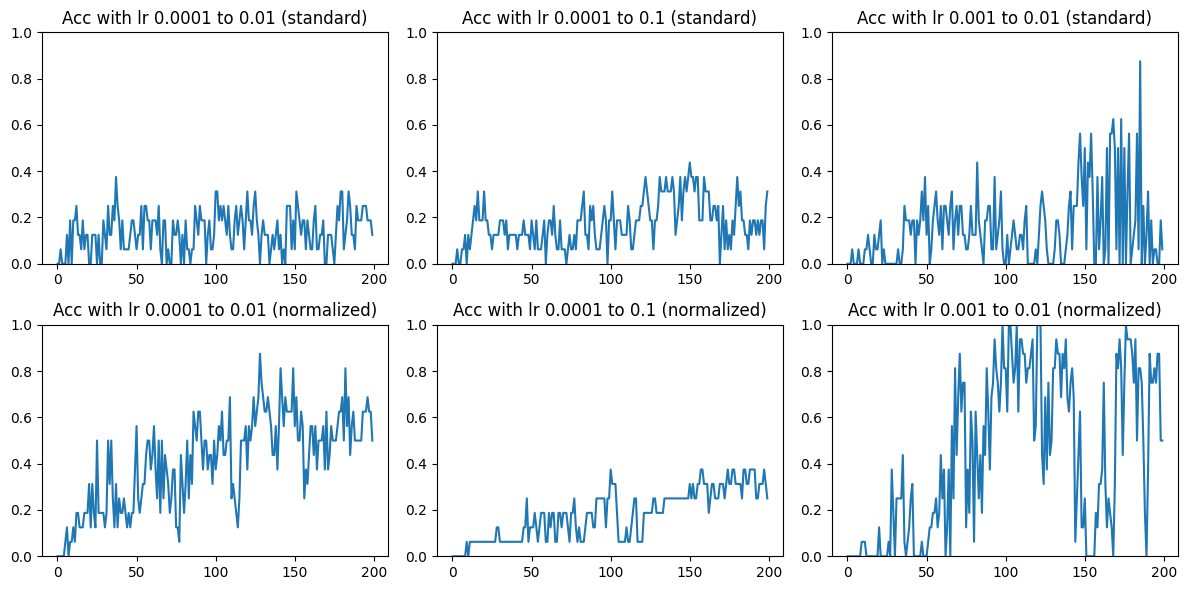

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=len(lr_to_test), figsize=(12, 6))

for i, (lr_base, lr_max) in enumerate(lr_to_test):
    axes[0, i].plot(full_standard_acc_history[i, :])
    axes[0, i].set_title(f'Acc with lr {lr_base} to {lr_max} (standard)')
    axes[0, i].set_ylim(0, 1)


for i, (lr_base, lr_max) in enumerate(lr_to_test):
    axes[1, i].plot(full_normalized_acc_history[i, :])
    axes[1, i].set_title(f'Acc with lr {lr_base} to {lr_max} (normalized)')
    axes[1, i].set_ylim(0, 1)


# print(full_normalized_acc)



# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()





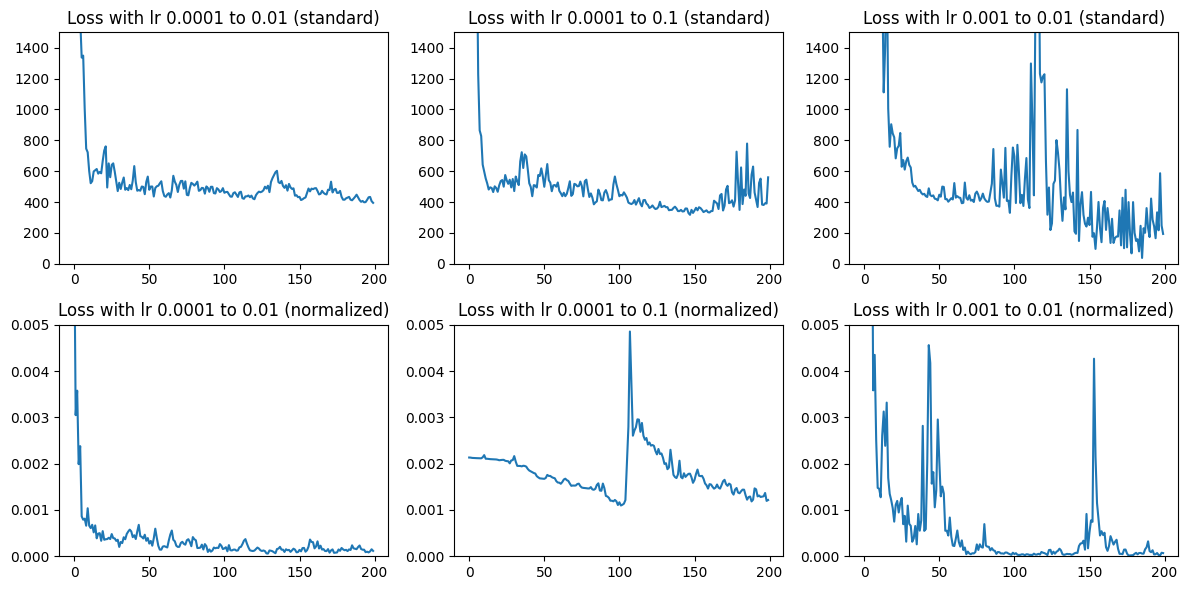

In [ ]:
# Loss
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x3 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=len(lr_to_test), figsize=(12, 6))

for i, (lr_base, lr_max) in enumerate(lr_to_test):
    axes[0, i].plot(full_standard_loss_history[i, :])
    axes[0, i].set_title(f'Loss with lr {lr_base} to {lr_max} (standard)')
    axes[0, i].set_ylim(0, 1500)



for i, (lr_base, lr_max) in enumerate(lr_to_test):
    axes[1, i].plot(full_normalized_loss_history[i, :])
    axes[1, i].set_title(f'Loss with lr {lr_base} to {lr_max} (normalized)')
    axes[1, i].set_ylim(0, 0.005)




# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()





In [ ]:
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_acc.npy', full_standard_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy', full_normalized_acc)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_standard_loss.npy', full_standard_loss)
#np.save(f'/content/gdrive/MyDrive/license_plate/models/full_normalized_loss.npy', full_normalized_loss)

a = np.load('/content/gdrive/MyDrive/license_plate/models/full_normalized_acc.npy')
print(a)

### Experiment : Removing layers from mobilenet


Explain what has been done: ...

In [ ]:
import torch
import torch.nn as nn

# Function to create the modified classifier
def create_custom_classifier(input_features, hidden_units, output_features):
    classifier = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.0),
        nn.Linear(hidden_units, output_features),
    )
    return classifier

# Function to create a new MobileNetV3 model with modified layers
def get_modified_mobilenet(num_layers_to_remove):
    if not (1 <= num_layers_to_remove <= 12):
        raise ValueError("num_layers_to_remove should be between 1 and 12.")

    # Load a pre-trained MobileNetV3 model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v3_large', pretrained=True)

    # Remove some layers from the features module
    model.features = nn.Sequential(*list(model.features.children())[:-num_layers_to_remove])

    # Update the input size of the custom classifier to match the output size of the modified features module
    input_features = model.features[-1].out_channels
    model.classifier = create_custom_classifier(input_features, hidden_units=100, output_features=4)

    # Number of layers you want to fine-tune
    layers_of_classifier = len(model.classifier)

    # Get all the parameters from the model as a list
    parameters = list(model.parameters())

    # The total number of layers is the length of the parameters list
    number_of_layers = len(parameters)

    # Calculate the number of pretrained layers (all except the last 'layers_of_classifier')
    pretrained_layers = number_of_layers - layers_of_classifier

    # Freeze the parameters of the pretrained base layers
    for param in parameters[:-layers_of_classifier]:
        param.requires_grad = False

    # Unfreeze the parameters of the last 'layers_of_classifier' layers
    for param in parameters[-layers_of_classifier:]:
        param.requires_grad = True

    # Set the model to evaluation mode if not training
    model.eval()
    return model

# # Get the modified model
# modified_model = get_modified_mobilenet()

# # Print the modified model architecture
# print(modified_model)

# check_requires_grad(modified_model)

In [ ]:
# Define model, loss function, optimizers, and schedulers
model = get_modified_mobilenet(num_layers_to_remove=3)

trained_model = train_full_model(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Input dimensions to custom classifier: 160
Starting training with decoder...


 20%|██        | 1/5 [00:02<00:11,  2.93s/it]

Epoch 1, In-sample Loss: 0.2146, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.2183, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [00:05<00:03,  1.92s/it]

Epoch 3, In-sample Loss: 0.1101, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.1203, Out-sample Accuracy: 0.0000


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 5, In-sample Loss: 0.0212, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0324, Out-sample Accuracy: 0.0000
Decoder training completed.
Starting full model training with cyclic LR ...


 20%|██        | 1/5 [00:03<00:14,  3.61s/it]

Epoch 1, In-sample Loss: 0.0207, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0316, Out-sample Accuracy: 0.0000


 60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

Epoch 3, In-sample Loss: 0.0106, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0214, Out-sample Accuracy: 0.0000


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


Epoch 5, In-sample Loss: 0.0049, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0108, Out-sample Accuracy: 0.0000
Full model training completed.
Starting full model training with linear LR ...
Adjusting learning rate of group 0 to 1.0000e-04.


  0%|          | 0/5 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-05.


 20%|██        | 1/5 [00:02<00:09,  2.35s/it]

Epoch 1, In-sample Loss: 0.0040, In-sample Accuracy: 0.0000
Epoch 1, Out-sample Loss: 0.0096, Out-sample Accuracy: 0.0000


 40%|████      | 2/5 [00:03<00:04,  1.47s/it]

Adjusting learning rate of group 0 to 2.5000e-05.
Adjusting learning rate of group 0 to 1.2500e-05.


 60%|██████    | 3/5 [00:05<00:03,  1.90s/it]

Epoch 3, In-sample Loss: 0.0037, In-sample Accuracy: 0.0000
Epoch 3, Out-sample Loss: 0.0093, Out-sample Accuracy: 0.0000


 80%|████████  | 4/5 [00:06<00:01,  1.49s/it]

Adjusting learning rate of group 0 to 6.2500e-06.
Adjusting learning rate of group 0 to 3.1250e-06.


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

Epoch 5, In-sample Loss: 0.0036, In-sample Accuracy: 0.0000
Epoch 5, Out-sample Loss: 0.0093, Out-sample Accuracy: 0.0000


### Plot data

In [ ]:
# #print a trainset with predicted label
# # train_loader = DataLoader(data_loader, batch_size=1, shuffle=True, num_workers=1)

# train_iter = iter(train_loader)

# batch = next(train_iter)

# X_batch, y_batch, _ = batch

# image = batch[0][0]
# labels = batch[1][0]

# # Get predicted labels
# X_batch = X_batch.permute(0,3,1,2).to(device)
# pred = model(X_batch)
# print(image.shape)
# plot_img_and_boundingbox(image, labels)
# plot_img_and_boundingbox(image, pred[0])

In [ ]:
# # Print a validation image with its predicted labels

# validationloader = DataLoader(test_loader, batch_size=1, shuffle=True, num_workers=1)

# validationloader_iter = iter(validationloader)

# batch = next(validationloader_iter)

# X_batch, y_batch, _ = batch
# print(X_batch.shape)
# print(y_batch.shape)

# image = batch[0][0]
# labels = batch[1][0]

# # Get predicted labels
# X_batch = X_batch.permute(0,3,1,2).to(device)
# print(X_batch.shape)
# pred = model(X_batch)

# plot_img_and_boundingbox(image, labels)

In [ ]:
# plot_img_and_boundingbox(image,pred[0])
# print(pred)
# print(calculate_true_positives_in_batch(labels.view(1,4),pred[0].view(1,4))) # Need to change view since we dont have batch